## Composite, non-linear rheology:


The viscous rheology in this model is similar to the Garel et al paper cited below. Other parts of the model setup are similar to Čížková and Bina (2015), Arredondo and Billen (2016) and Korenaga (2011). 

Here we use a dimensionless system. For the psuedo-plastic effective rheology a Drucker-prager model is used.


**Keywords:** subduction, composite rheology, dislocation creep


**References:**


Garel, Fanny, et al. "Interaction of subducted slabs with the mantle transition‐zone: A regime diagram from 2‐D thermo‐mechanical models with a mobile trench and an overriding plate." Geochemistry, Geophysics, Geosystems 15.5 (2014): 1739-1765.

Čížková, Hana, and Craig R. Bina. "Geodynamics of trench advance: Insights from a Philippine-Sea-style geometry." Earth and Planetary Science Letters 430 (2015): 408-415.

Arredondo, Katrina M., and Magali I. Billen. "The Effects of Phase Transitions and Compositional Layering in Two-dimensional Kinematic Models of Subduction." Journal of Geodynamics (2016).


In [1]:
import numpy as np
import underworld as uw
import math
from underworld import function as fn
import glucifer

import os
import sys
import natsort
import shutil
from easydict import EasyDict as edict
import operator
import pint
import time
import operator
from slippy2 import boundary_layer2d
from slippy2 import material_graph
from slippy2 import spmesh
from slippy2 import phase_function
from unsupported.interfaces import markerLine2D


from mpi4py import MPI
comm = MPI.COMM_WORLD
rank = comm.Get_rank()

/root/underworld2/unsupported/interfaces/__init__.py:9: UserWarning: 

The interface module is not supported.
Questions should be addressed to louis.moresi@unimelb.edu.au 
 
  Questions should be addressed to louis.moresi@unimelb.edu.au \n """


In [2]:
#store = glucifer.Store('subduction')
#figParticle = glucifer.Figure( store, figsize=(960,300), name="Particles" )

#figParticle.save_database('test.gldb')

Model name and directories
-----

In [3]:
############
#Model letter and number
############


#Model letter identifier default
Model = "T"

#Model number identifier default:
ModNum = 0

#Any isolated letter / integer command line args are interpreted as Model/ModelNum

if len(sys.argv) == 1:
    ModNum = ModNum 
elif sys.argv[1] == '-f': #
    ModNum = ModNum 
else:
    for farg in sys.argv[1:]:
        if not '=' in farg: #then Assume it's a not a paramter argument
            try:
                ModNum = int(farg) #try to convert everingthing to a float, else remains string
            except ValueError:
                Model  = farg

In [4]:
###########
#Standard output directory setup
###########


outputPath = "results" + "/" +  str(Model) + "/" + str(ModNum) + "/" 
imagePath = outputPath + 'images/'
filePath = outputPath + 'files/'
checkpointPath = outputPath + 'checkpoint/'
dbPath = outputPath + 'gldbs/'
outputFile = 'results_model' + Model + '_' + str(ModNum) + '.dat'

if uw.rank()==0:
    # make directories if they don't exist
    if not os.path.isdir(outputPath):
        os.makedirs(outputPath)
    if not os.path.isdir(checkpointPath):
        os.makedirs(checkpointPath)
    if not os.path.isdir(imagePath):
        os.makedirs(imagePath)
    if not os.path.isdir(dbPath):
        os.makedirs(dbPath)
    if not os.path.isdir(filePath):
        os.makedirs(filePath)
        
comm.Barrier() #Barrier here so no procs run the check in the next cell too early

In [5]:
###########
#Check if starting from checkpoint
###########

checkdirs = []
for dirpath, dirnames, files in os.walk(checkpointPath):
    if files:
        print dirpath, 'has files'
        checkpointLoad = True
        checkdirs.append(dirpath)
    if not files:
        print dirpath, 'is empty'
        checkpointLoad = False

results/T/0/checkpoint/ is empty


In [6]:
# setup summary output file (name above)
if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    if uw.rank() == 0:
        shutil.copyfile(os.path.join(checkpointLoadDir, outputFile), outputPath+outputFile)
    comm.Barrier()
    f_o = open(os.path.join(outputPath, outputFile), 'a')
    prevdata = np.genfromtxt(os.path.join(outputPath, outputFile), skip_header=0, skip_footer=0)
    if len(prevdata.shape) == 1: #this is in case there is only one line in previous file
        realtime = prevdata[-1]  #This corresponds to the column you write time data to
    else:
        realtime = prevdata[prevdata.shape[0]-1, -1]
    step = int(checkpointLoadDir.split('/')[-1])
    timevals = [0.]
else:
    f_o = open(outputPath+outputFile, 'w')
    realtime = 0.
    step = 0
    timevals = [0.]

Setup parameters
-----

Set simulation parameters for test.

**Use pint to setup any unit conversions we'll need**

In [7]:
u = pint.UnitRegistry()
cmpery = 1.*u.cm/u.year
mpermy = 1.*u.m/u.megayear
year = 1.*u.year
spery = year.to(u.sec)
cmpery.to(mpermy)

/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:98: DeprecationWarning: DisplayFormatter._formatters_default is deprecated: use @default decorator instead.
  def _formatters_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:677: DeprecationWarning: PlainTextFormatter._deferred_printers_default is deprecated: use @default decorator instead.
  def _deferred_printers_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):
/usr/local/lib/python2.7/dist-packages/IPython/core/formatters.py:672: DeprecationWarning: PlainTextFormat

<Quantity(10000.0, 'meter / megayear')>

In [8]:
box_half_width =4000e3
age_at_trench = 100e6
cmperyear = box_half_width / age_at_trench #m/y
mpersec = cmperyear*(cmpery.to(u.m/u.second)).magnitude #m/sec
print(cmperyear, mpersec )

(0.04, 1.2675505856327397e-11)


**Set parameter dictionaries**

* Parameters are stored in dictionaries. 
* If starting from checkpoint, parameters are loaded using pickle
* If params are passed in as flags to the script, they overwrite 

In [9]:
###########
#Parameter / settings dictionaries get saved&loaded using pickle
###########
 
dp = edict({}) #dimensional parameters
sf = edict({}) #scaling factors
ndp = edict({}) #dimensionless paramters
md = edict({}) #model paramters, flags etc
#od = edict({}) #output frequencies


In [10]:
dict_list = [dp, sf, ndp, md]
dict_names = ['dp.pkl', 'sf.pkl', 'ndp.pkl', 'md.pkl']

def save_pickles(dict_list, dict_names, dictPath):
    import pickle
    counter = 0
    for pdict in dict_list:
        myfile = os.path.join(dictPath, dict_names[counter])
        with open(myfile, 'wb') as f:
            pickle.dump(pdict, f)
        counter+=1


#ended up having to pretty much write a hard-coded function
#All dictionaries we want checkpointed will have to  be added here 
#and where the function is called
#Fortunately, this function is only called ONCE

def load_pickles():
    import pickle
    dirpath = os.path.join(checkpointPath, str(step))
    dpfile = open(os.path.join(dirpath, 'dp.pkl'), 'r')
    dp = pickle.load(dpfile)
#    #
    ndpfile = open(os.path.join(dirpath, 'ndp.pkl'), 'r')
    ndp = edict(pickle.load(ndpfile))
    #
    sffile = open(os.path.join(dirpath, 'sf.pkl'), 'r')
    sf = edict(pickle.load(sffile))
    #
    mdfile = open(os.path.join(dirpath, 'md.pkl'), 'r')
    md = edict(pickle.load(mdfile))
    return dp, ndp, sf, md

In [11]:
###########
#Store the physical parameters, scale factors and dimensionless pramters in easyDicts
#Mainly helps with avoiding overwriting variables
###########


#Style => parameters_like_this

dp = edict({#Main physical paramters
           'depth':0.5*2900.*1e3, #Depth
           'LS':2900.*1e3, #Length scale
           'rho':3300.,  #reference density
           'g':9.8, #surface gravity
           'eta0':1e20, #Dislocation creep at 250 km, 1573 K, 1e-15 s-1 
           'k':1e-6, #thermal diffusivity
           'a':3e-5, #surface thermal expansivity
           'R':8.314, #gas constant
           'Cp':1250., #Specific heat (Jkg-1K-1)
           'TP':1573., #mantle potential temp (K)
           'TS':273., #surface temp (K)
            #Rheology - flow law paramters
           'cm':2e6, #mantle cohesion in Byerlee law
           'cc':2e6, #mantle cohesion in Byerlee law
           'ci':2e6, #mantle cohesion in Byerlee law
           'cf':2e6, #mantle cohesion in Byerlee law
           'fcm':0.2,   #mantle friction coefficient in Byerlee law (tan(phi))
           'fcc':0.01,   #crust friction coefficient 
           'fci':0.01,   #subduction interface friction coefficient
           'fcf':0.03,   #subduction interface friction coefficient
           'Adf':3e-11, #pre-exp factor for diffusion creep
           'Ads':5e-16, #pre-exp factor for dislocation creep
           'Apr':1e-150,#pre-exp factor for Peierls creep
           'Edf':3e5,
           'Eds':5.4e5,
           'Epr':5.4e5,
           'Vdf':4e-6,
           'Vds':12e-6,
           'Vpr':10e-6,
           'Alm':2e-16,
           'Elm':2.0e5,
           'Vlm':1.5e-6,
           'SR':1e-15, #reference strain rate
           'n':3.5, #Dislocation creep stress exponent
           'np':20., #Peierls creep stress exponent 
           #Rheology - cutoff values
           'eta_min':1e17, 
           'eta_max':1e25, #viscosity max in the mantle material
           'eta_min_crust':1e17, #viscosity min in the weak-crust material
           'eta_max_crust':0.5*1e20, #viscosity max in the weak-crust material
           'eta_min_interface':1e17, #viscosity min in the subduction interface material
           'eta_max_interface':0.5*1e20, #viscosity max in the subduction interface material
           'eta_min_fault':1e20, #viscosity min in the subduction interface material
           'eta_max_fault':1e20, #viscosity max in the subduction interface material
           #Length scales
           'MANTLETOCRUST':8.*1e3, #Crust depth
           'HARZBURGDEPTH':40e3,
           'CRUSTTOMANTLE':800.*1e3,
           'LITHTOMANTLE':(900.*1e3),
           'MANTLETOLITH':200.*1e3, 
           'TOPOHEIGHT':10.*1e3,  #rock-air topography limits
           'CRUSTTOECL':100.*1e3,
           'LOWMANTLEDEPTH':660.*1e3, 
           'CRUSTVISCUTOFF':150.*1e3, #Deeper than this, crust material rheology reverts to mantle rheology
           'AGETRACKDEPTH':100e3, #above this depth we track the age of the lithsphere (below age is assumed zero)
           #Slab and plate parameters
           'roc':250e3,     #radius of curvature of slab
           'subzone':0.0,   #X position of subduction zone...km
           'lRidge':-1.*(5000e3),  #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
           'rRidge':(5000e3),
           'maxDepth':250e3,
           'theta':70., #Angle to truncate the slab (can also control with a maxDepth param)
           'slabmaxAge':60e6, #age of subduction plate at trench
           'platemaxAge':60e6, #max age of slab (Plate model)
           'sense':'Right', #dip direction
           'op_age_fac':0.5, #this controls the overidding plate age reduction
           #Misc
           'rDepth':250e3, #reference depth (used to scale / normalize the flow laws)
           'StALS':100e3, #depth of sticky air layer
           'Steta_n':1e19, #stick air viscosity, normal
           'Steta_s':1e18, #stick air viscosity, shear 
           'plate_vel':4,
           'low_mantle_visc_fac':10.
             })

#append any derived parameters to the dictionary
#Adiabatic heating stuff

dp.dTa = (dp.a*dp.g*(dp.TP))/dp.Cp #adibatic gradient, at Tp
dp.deltaTa = (dp.TP + dp.dTa*dp.LS) - dp.TS  #Adiabatic Temp at base of mantle, minus Ts
dp.rTemp= dp.TP + dp.rDepth*dp.dTa #reference temp, (potential temp + adiabat)


In [12]:
10/2.9

3.4482758620689657

In [13]:
#Modelling and Physics switches

md = edict({'refineMesh':True,
            'stickyAir':False,
            'subductionFault':False,
            'symmetricIcs':False,
            'velBcs':False,
            'aspectRatio':6.89, # 2*Aspect ratio of the garel model, i.e preserves width when only half depth is used
            'compBuoyancy':False, #use compositional & phase buoyancy, or simply thermal
            'periodicBcs':False,
            'RES':128,
            'PIC_integration':True,
            'ppc':25,
            'elementType':"Q1/dQ0",
            'compBuoyancy':False, #use compositional & phase buoyancy, or simply thermal
            'viscMechs':['diffusion', 'dislocation', 'peierls', 'yielding'],
            'viscCombine':'harmonic' #'harmonic', 'min', 'mixed'....
            })

In [14]:
###########
#If starting from a checkpoint load params from file
###########

if checkpointLoad:
    dp, ndp, sf, md = load_pickles()  #remember to add any extra dictionaries

In [15]:
###########
#If command line args are given, overwrite
#Note that this assumes that params as commans line args/
#only append to the 'dimensional' and 'model' dictionary (not the non-dimensional)
###########    


###########
#If extra arguments are provided to the script" eg:
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3=3.0
###
###This would assign ModNum = 2, all other values go into the dp dictionary, under key names provided
###
###Two operators are searched for, = & *=
###
###If =, parameter is re-assigned to givn value
###If *=, parameter is multipled by given value
###
### >>> uw.py 2 dp.arg1=1 dp.arg2=foo dp.arg3*=3.0
###########

for farg in sys.argv[1:]:
    try:
        (dicitem,val) = farg.split("=") #Split on equals operator
        (dic,arg) = dicitem.split(".") #colon notation
        if '*=' in farg:
            (dicitem,val) = farg.split("*=") #If in-place multiplication, split on '*='
            (dic,arg) = dicitem.split(".")
            
        if val == 'True': 
            val = True
        elif val == 'False':     #First check if args are boolean
            val = False
        else:
            try:
                val = float(val) #next try to convert  to a float,
            except ValueError:
                pass             #otherwise leave as string
        #Update the dictionary
        if farg.startswith('dp'):
            if '*=' in farg:
                dp[arg] = dp[arg]*val #multiply parameter by given factor
            else:
                dp[arg] = val    #or reassign parameter by given value
        if farg.startswith('md'):
            if '*=' in farg:
                md[arg] = md[arg]*val #multiply parameter by given factor
            else:
                md[arg] = val    #or reassign parameter by given value
                
    except:
        pass
            

comm.barrier()

In [16]:
if not checkpointLoad:
    
    #Scaling factors, used to map the dimensional parameters to dimensionless
    
    sf = edict({'stress':dp.LS**2/(dp.k*dp.eta0),
            'lith_grad':dp.rho*dp.g*(dp.LS)**3/(dp.eta0*dp.k) ,
            'vel':dp.LS/dp.k,
            'SR':dp.LS**2/dp.k,
            'W':(dp.rho*dp.g*dp.LS)/(dp.R*dp.deltaTa), #Including adiabatic compression, and deltaTa
            'E': 1./(dp.R*dp.deltaTa), #using deltaTa, the guesstimated adiabatic temp differnnce to scale these paramters
            #'Ads':(dp.eta0**(ndp.n-2))*((dp.k)**(ndp.n-1))*((dp.LS)**(2. - 2*ndp.n))       
           })
    
     #dimensionless parameters
    ndp = edict({'RA':(dp.g*dp.rho*dp.a*dp.deltaTa*(dp.LS)**3)/(dp.k*dp.eta0),
             'Di': dp.a*dp.g*dp.LS/dp.Cp, #Dissipation number
             'H':0.,
             #Temperatures and reference depth
             'TSP':0., #dimensionless potential temp
             'TPP':(dp.TP - dp.TS)/dp.deltaTa, #dimensionless potential temp
             'TS':dp.TS/dp.deltaTa,
             'TP':dp.TP/dp.deltaTa,
             'rTemp':(dp.rTemp- dp.TS)/dp.deltaTa,
             'rDepth':dp.rDepth/dp.LS,
              #Rheology - flow law paramters        
             'Wdf':dp.Vdf*sf.W,
             'Edf':dp.Edf*sf.E,
             'Wps':dp.Vpr*sf.W,
             'Eps':dp.Epr*sf.E,
             'Wds':dp.Vds*sf.W,      #{df  => diffusion creep}
             'Eds':dp.Eds*sf.E,      #{ds  => dislocation creep}
             'Elm':dp.Elm*sf.E,      #{pr  => Peierls creep}
             'Elm':dp.Elm*sf.E,
             'Wlm':dp.Vlm*sf.W,
             'cm':dp.cm*sf.stress,
             'cc':dp.cc*sf.stress,    #{dimensionless cohesion in mantl, crust, interface}
             'ci':dp.ci*sf.stress,
             'cf':dp.cf*sf.stress,
             'fcmd':dp.fcm*sf.lith_grad, 
             'fccd':dp.fcc*sf.lith_grad, #{dimensionless friction coefficient in mantle, crust, interface}
             'fcid':dp.fci*sf.lith_grad,
             'fcfd':dp.fci*sf.lith_grad,
             'n':dp.n, #Dislocation creep stress exponent
             'np':dp.np, #Peierls creep stress exponent 
             #Rheology - cutoff values
             'eta_min':dp.eta_min/dp.eta0, 
             'eta_max':dp.eta_max/dp.eta0, #viscosity max in the mantle material
             'eta_min_crust':dp.eta_min_crust/dp.eta0, #viscosity min in the weak-crust material
             'eta_max_crust':dp.eta_max_crust/dp.eta0, #viscosity max in the weak-crust material
             'eta_min_interface':dp.eta_min_interface/dp.eta0, #viscosity min in the subduction interface material
             'eta_max_interface':dp.eta_max_interface/dp.eta0, #viscosity max in the subduction interface material
             'eta_min_fault':dp.eta_min_fault/dp.eta0, #viscosity min in the subduction interface material
             'eta_max_fault':dp.eta_max_fault/dp.eta0, #viscosity max in the subduction interface material 
             #Lengths scales
             'MANTLETOCRUST':dp.MANTLETOCRUST/dp.LS, #Crust depth
             'HARZBURGDEPTH':dp.HARZBURGDEPTH/dp.LS,
             'CRUSTTOMANTLE':dp.CRUSTTOMANTLE/dp.LS,
             'LITHTOMANTLE':dp.LITHTOMANTLE/dp.LS,
             'MANTLETOLITH':dp.MANTLETOLITH/dp.LS,
             'TOPOHEIGHT':dp.TOPOHEIGHT/dp.LS,  #rock-air topography limits
             'CRUSTTOECL':dp.CRUSTTOECL/dp.LS,
             'LOWMANTLEDEPTH':dp.LOWMANTLEDEPTH/dp.LS, 
             'CRUSTVISCUTOFF':dp.CRUSTVISCUTOFF/dp.LS, #Deeper than this, crust material rheology reverts to mantle rheology
             'AGETRACKDEPTH':dp.AGETRACKDEPTH/dp.LS,
             #Slab and plate parameters
             'roc':dp.roc/dp.LS,         #radius of curvature of slab
             'subzone':dp.subzone/dp.LS, #X position of subduction zone...km
             'lRidge':dp.lRidge/dp.LS,   #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
             'rRidge':dp.rRidge/dp.LS,
             'maxDepth':dp.maxDepth/dp.LS,
             #Misc
             'Steta_n':dp.Steta_n/dp.eta0, #stick air viscosity, normal
             'Steta_s':dp.Steta_n/dp.eta0, #stick air viscosity, shear 
             'StALS':dp.StALS/dp.LS,
             'plate_vel':sf.vel*dp.plate_vel*(cmpery.to(u.m/u.second)).magnitude,
             'low_mantle_visc_fac':dp.low_mantle_visc_fac
            })

    #Append any more derived paramters
    ndp.SR = dp.SR*sf.SR #characteristic strain rate
    ndp.StRA = (3300.*dp.g*(dp.LS)**3)/(dp.eta0 *dp.k) #Composisitional Rayleigh number for rock-air buoyancy force
    ndp.TaP = 1. - ndp.TPP,  #Dimensionles adiabtic component of deltaT

**Model/ mesh  setup parameters**

In [17]:
###########
#Model setup parameters
###########

dim = 2          # number of spatial dimensions


#Domain and Mesh paramters
Xres = int(md.RES*8)


hw = np.round(5000e3/dp.LS, 1)
MINX = -1*hw
MINY = 1. - (dp.depth/dp.LS)


MAXX = hw
MAXY = 1.


if md.stickyAir:
    Yres = int(md.RES)
    MAXY = 1. + dp.StALS/dp.LS #150km
    
else:
    Yres = int(md.RES)
    MAXY = 1.


periodic = [False, False]
if md.periodicBcs:
    periodic = [True, False]




#Metric output stuff
figures =  'gldb' #glucifer Store won't work on all machines, if not, set to 'gldb' 
swarm_repop, swarm_update = 10, 10
gldbs_output = 40
checkpoint_every, files_output = 50, 20 #checkpoint every needs to be greater or equal to metric_output 
metric_output = 20
sticky_air_temp = 1e6

In [18]:
mesh = uw.mesh.FeMesh_Cartesian( elementType = (md.elementType),
                                 elementRes  = (Xres, Yres), 
                                 minCoord    = (MINX, MINY), 
                                 maxCoord    = (MAXX, MAXY), periodic=periodic)

velocityField       = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=2 )
pressureField       = uw.mesh.MeshVariable( mesh=mesh.subMesh, nodeDofCount=1 )
temperatureField    = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )
temperatureDotField = uw.mesh.MeshVariable( mesh=mesh,         nodeDofCount=1 )

In [19]:
mesh.reset()


In [20]:
###########
#Mesh refinement
###########

#X-Axis

if md.refineMesh:
    mesh.reset()
    axis = 0
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (abs(mesh.maxCoord[axis]) - abs(mesh.minCoord[axis]))/2.
    el_reduction = 0.51
    dx = mesh.maxCoord[axis] - min_point

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction) *deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'x',norm = 'Min', constraints = [])

Min
(512, 0.0033867187499999774, 2.5840000000000054, 0.95999999999997443)
('edges', 512)
-- iteration 0 --
| F( p_n ) |^2: 2.1341247797e-05
| p_n+1 - p_n |^2: 11.8441792803
-- iteration 1 --
| F( p_n ) |^2: 4.40508176067e-30
Min, Max element width: 
0.00339
0.00989


/root/slippy2/slippy2/spmesh.py:213: DeprecationWarning: the sets module is deprecated
  from sets import ImmutableSet as Set


In [21]:
axis = 1
orgs = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)

value_to_constrain = 1.


yconst = [(spmesh.find_closest(orgs, value_to_constrain), np.array([value_to_constrain,0]))]

In [22]:
###########
#Mesh refinement
###########

if md.refineMesh:
    #Y-Axis
    axis = 1
    origcoords = np.linspace(mesh.minCoord[axis], mesh.maxCoord[axis], mesh.elementRes[axis] + 1)
    edge_rest_lengths = np.diff(origcoords)

    deform_lengths = edge_rest_lengths.copy()
    min_point =  (mesh.maxCoord[axis])
    el_reduction = 0.5
    dx = mesh.maxCoord[axis]

    deform_lengths = deform_lengths - \
                                    ((1.-el_reduction)*deform_lengths[0]) + \
                                    abs((origcoords[1:] - min_point))*((0.5*deform_lengths[0])/dx)

    #print(edge_rest_lengths.shape, deform_lengths.shape)

    spmesh.deform_1d(deform_lengths, mesh,axis = 'y',norm = 'Min', constraints = yconst)

Min
(64, 0.00390625, 0.3115234375, 3.0634920634920637)
('edges', 64)
-- iteration 0 --
| F( p_n ) |^2: 3.1486390129e-05
| p_n+1 - p_n |^2: 0.137599723049
-- iteration 1 --
| F( p_n ) |^2: 3.42851641287e-31
Min, Max element width: 
0.00391
0.01172


In [23]:
#THis is a hack for adding a sticky air domain, we refine MAXY and things like the temperature stencil work from Y = 1. 

if md.stickyAir:
    MAXY = 1.

Initial conditions
-------


In [24]:
coordinate = fn.input()
depthFn = 1. - coordinate[1] #a function providing the depth
xFn = coordinate[0]  #a function providing the x-coordinate
yFn = coordinate[1]  #a function providing the y-coordinate

potTempFn = ndp.TPP + (depthFn)*ndp.TaP #a function providing the adiabatic temp at any depth
abHeatFn = -1.*velocityField[1]*temperatureField*ndp.Di #a function providing the adiabatic heating rate

In [25]:
#ndp.TaP

In [26]:
def age_fn(xFn, sz = 0.0, lMOR=MINX, rMOR=MAXX, opFac=1., conjugate_plate = False):
    """
    Simple function to generate a discrete 1-d (i.e x-coordinate) function for the age of the thermal BC. 
    All paramters are dimensionless
    sz: location of subduction zone
    lMOR: location of left-hand MOR
    rMOR: location of right-hand MOR
    opFac: uniform reduce the age of the right hand plate by this factor
    conjugate_plate: if True, build plates on the outer sides of the MORs, if False, age = 0. 
    """
    
    if lMOR < MINX:
        lMOR = MINX
    if rMOR > MAXX:
        rMOR = MAXX
    r_grad =  1./(abs(rMOR-sz))
    l_grad =  1./(abs(sz-lMOR))
    if conjugate_plate:
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),
                                      (xFn > rMOR, r_grad*opFac*(xFn -abs(rMOR)) / (abs(MAXX-rMOR))),
                                      (True, l_grad*fn.math.abs((((xFn + abs(lMOR)) / (abs(lMOR - MINX))))))
                                         ])
    else:    
        
        ageFn = fn.branching.conditional([(operator.and_(xFn > lMOR, xFn < sz) , (xFn + abs(lMOR))/(abs(sz-lMOR))), 
                                      (operator.and_(xFn < rMOR, xFn >= sz), (1.-(xFn + abs(sz))/abs(rMOR-sz))*opFac),

                                      (True, 0.0)])
    return ageFn

In [27]:
###########
#Thermal initial condition:
#if symmetricIC, we build a symmetric downwelling on top of a sinusoidal perturbation
##########

#Sinusoidal initial condition
A = 0.2
sinFn = depthFn + A*(fn.math.cos( math.pi * coordinate[0])  * fn.math.sin( math.pi * coordinate[1] ))        
iD = 1000e3/dp.LS #Initial Slab depth
dl =  2*math.sqrt(dp.k*160e6*3600*24*365) #diffusion Length at ... My
w0 = dl/dp.LS #Boundary layer/slab initial condition
delX1 = fn.misc.min(fn.math.abs(coordinate[0] - -0.), fn.math.abs(coordinate[0] - -2.))
delX = fn.misc.min(delX1 , fn.math.abs(coordinate[0] - 2.))
w = w0*fn.math.sqrt(delX + 1e-7)
tempBL = (potTempFn) *fn.math.erf((depthFn)/w) + ndp.TSP
delX = fn.misc.min(fn.math.abs(coordinate[0] - - 1.) , fn.math.abs(coordinate[0] - 1.))
tempSlab = (potTempFn ) *fn.math.erf((delX*2.)/w0) + ndp.TSP       
tempFn1 =  fn.misc.min(tempBL, tempSlab)
blFn = fn.branching.conditional([(depthFn < iD, tempFn1), 
                                    (True, potTempFn)])

tempFn = 0.*sinFn + 1.*blFn #partition the temp between these the symmetric downwelling and sinusoid
if md.symmetricIcs:  
    if not checkpointLoad:
        temperatureField.data[:] = tempFn.evaluate(mesh)  

###########
#Thermal initial condition 2: 
#if symmetricIC == False, we build an asymmetric subduction-zone
###########

#Main control paramters are:

Roc = 250e3 #radius of curvature of slab

theta = 75. #Angle to truncate the slab (can also do with with a cutoff depth)
subzone = 0.0 #X position of subduction zone...in model coordinates
slabmaxAge = 125e6 #age of subduction plate at trench
platemaxAge = 125e6 #max age of slab (Plate model)
ageAtTrenchSeconds = min(platemaxAge*(3600*24*365), slabmaxAge*(3600*24*365))


sense = 'Right' #dip direction
op_age_fac = 0.2 #this controls the overidding plate speed, hence age reduction


#First build the top TBL
#lRidge = -0.5*(670e3*4)/dp.LS_SC  #For depth = 670 km, aspect ratio of 4, this puts the ridges at MINX, MAXX
#rRidge = 0.5*(670e3*4)/dp.LS_SC

#ageFn = age_fn(xFn, sz = -0.5, lMOR=-2., rMOR=2.)
ageFn = age_fn(xFn, sz =0., opFac=op_age_fac, conjugate_plate=True)

#dimensionlize the age function
ageFn *= slabmaxAge*(3600*24*365)
#ageFn = fn.misc.min(ageFn, platemaxAge*(3600*24*365)) #apply plate model

w0 = (2.3*math.sqrt(dp.k*ageAtTrenchSeconds))/dp.LS #diffusion depth of plate at the trench

tempBL = (potTempFn) *fn.math.erf((depthFn*dp.LS)/(2.*fn.math.sqrt(dp.k*ageFn))) + ndp.TSP #boundary layer function

tempTBL =  fn.branching.conditional([(depthFn < w0, tempBL),
                          (True, potTempFn)])

if not md.symmetricIcs:
    if not checkpointLoad:
        out = uw.utils.MeshVariable_Projection( temperatureField, tempTBL) #apply function with projection
        out.solve()


#Now build the perturbation part
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2

#Setup slab perturbation params (mostly dimensionlesl / model params here)
phi = 90. - theta
RocM = (Roc/dp.LS)
CrustM = ndp.MANTLETOCRUST
Org = (subzone, 1.-RocM)
maxDepth = 194e3/dp.LS

#We use three circles to define our slab and crust perturbation,  
Oc = inCircleFnGenerator(Org , RocM)
Oc2 = inCircleFnGenerator(Org , RocM + (0.5*CrustM)) #increases the amount of crust in the interface
Ic = inCircleFnGenerator(Org , RocM - w0)
Cc = inCircleFnGenerator(Org , RocM - (1.*CrustM)) #... weak zone on 'inside' of slab
Hc = inCircleFnGenerator(Org , RocM - ndp.HARZBURGDEPTH) #... Harzburgite layer 
dx = (RocM)/(np.math.tan((np.math.pi/180.)*phi))

#We'll also create a triangle which will truncate the circles defining the slab...
if sense == 'Left':
    ptx = subzone - dx
else:
    ptx = subzone + dx
coords = ((0.+subzone, 1), (0.+subzone, 1.-RocM), (ptx, 1.))
Tri = fn.shape.Polygon(np.array(coords))

#Actually apply the perturbation
if not md.symmetricIcs:
    if not checkpointLoad:
        sdFn = ((RocM - fn.math.sqrt((coordinate[0] - Org[0])**2. + (coordinate[1] - Org[1])**2.)))
        slabFn = ndp.TPP*fn.math.erf((sdFn*dp.LS)/(2.*math.sqrt(dp.k*ageAtTrenchSeconds))) + ndp.TSP
        for index, coord in enumerate(mesh.data):
            if (
                Oc.evaluate(tuple(coord)) and
                Tri.evaluate(tuple(coord)) and not
                Ic.evaluate(tuple(coord)) and
                coord[1] > (1. - maxDepth)
                ): #In the quarter-circle defining the lithosphere
                temperatureField.data[index] = slabFn.evaluate(mesh)[index]



In [28]:
###########
#Thermal initial condition - half-space cooling
###########

#  a few conversions
ageAtTrenchSeconds = min(dp.platemaxAge*(3600*24*365), dp.slabmaxAge*(3600*24*365))
#slab perturbation params (mostly dimensionless / model params here)
phi = 90. - dp.theta
Org = (ndp.subzone, MAXY-ndp.roc)

#First build the top TBL
ageFn = age_fn(xFn, sz =ndp.subzone, lMOR=ndp.lRidge,rMOR=ndp.rRidge, conjugate_plate=True, opFac = dp.op_age_fac)
#dimensionlize the age function
ageFn *= ageAtTrenchSeconds #seconds to year
w0 = (2.3*math.sqrt(dp.k*ageAtTrenchSeconds))/dp.LS #diffusion depth of plate at the trench

tempBL = (ndp.TPP - ndp.TSP)*fn.math.erf((depthFn*dp.LS)/(2.*fn.math.sqrt(dp.k*ageFn))) + ndp.TSP #boundary layer function
tempTBL =  fn.branching.conditional([(depthFn < w0, tempBL),
                          (True, ndp.TPP)])

if not md.symmetricIcs:
    if not checkpointLoad:
        out = uw.utils.MeshVariable_Projection( temperatureField, tempTBL) #apply function with projection
        out.solve()



In [29]:
#Now build the perturbation part
def inCircleFnGenerator(centre, radius):
    coord = fn.input()
    offsetFn = coord - centre
    return fn.math.dot( offsetFn, offsetFn ) < radius**2



#We use three circles to define our slab and crust perturbation,  
Oc = inCircleFnGenerator(Org , ndp.roc)
Oc2 = inCircleFnGenerator(Org , ndp.roc + (0.5*ndp.MANTLETOCRUST)) #increases the amount of crust in the interface
Ic = inCircleFnGenerator(Org , ndp.roc - w0)
Cc = inCircleFnGenerator(Org , ndp.roc - (1.2*ndp.MANTLETOCRUST)) #... weak zone on 'outside' of slab
Hc = inCircleFnGenerator(Org , ndp.roc - ndp.HARZBURGDEPTH) #... Harzburgite layer 
dx = (ndp.roc)/(np.math.tan((np.math.pi/180.)*phi))

#We'll also create a triangle which will truncate the circles defining the slab...
if dp.sense == 'Left':
    ptx = ndp.subzone - dx
else:
    ptx = ndp.subzone + dx
coords = ((0.+ ndp.subzone, MAXY), (0.+ ndp.subzone, MAXY-ndp.roc), (ptx, MAXY))
Tri = fn.shape.Polygon(np.array(coords))

#Actually apply the perturbation - could probably avoid particle walk here
if not md.symmetricIcs:
    if not checkpointLoad:
        sdFn = ((ndp.roc - fn.math.sqrt((coordinate[0] - Org[0])**2. + (coordinate[1] - Org[1])**2.)))
        slabFn = ndp.TPP*fn.math.erf((sdFn*dp.LS)/(2.*math.sqrt(dp.k*ageAtTrenchSeconds))) + ndp.TSP
        for index, coord in enumerate(mesh.data):
            if (
                Oc.evaluate(tuple(coord)) and
                Tri.evaluate(tuple(coord)) and not
                Ic.evaluate(tuple(coord)) and
                coord[1] > (MAXY - ndp.maxDepth)
                ): #In the quarter-circle defining the lithosphere
                temperatureField.data[index] = slabFn.evaluate(mesh)[index]


In [30]:
#Make sure material in sticky air region is at the surface temperature.
for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP

def matplot_field(temperatureField, dp):
    if uw.nProcs() != 1:
        print("only in Serial folks")
    else:
        import matplotlib.pyplot as pyplt
        try :
            if(__IPYTHON__) :
                get_ipython().magic(u'matplotlib inline')
        except NameError :
            pass
        field_data = temperatureField.data.reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1)
        fig, ax = pyplt.subplots(figsize=(32,2))
        ql = dp.LS/1e3
        pyplt.ioff()
        cax =ax.imshow(np.flipud(field_data), cmap='coolwarm', aspect = 0.5, extent=[0,ql*aspectRatio,ql, 0])
        fig.colorbar(cax, orientation='horizontal' )
        #ax.set_x([0,dp.LS*aspectRatio])
        pyplt.tight_layout()
        
        return fig, ax
        
fig, ax = matplot_field(temperatureField, dp)
fig.savefig('test.png')       

In [31]:
fig= glucifer.Figure(quality=3)

#fig.append( glucifer.objects.Surface(mesh,temperatureField, discrete=True))
#fig.append( glucifer.objects.Mesh(mesh))
#fig.append( glucifer.objects.Points())
#fig.show()
#fig.save_database('test.gldb')


In [32]:
#ndp.RA*ndp.TPP, ndp.RA*temperatureField.data.max()
#ndp.TPP

Boundary conditions
-------

In [33]:
iWalls = mesh.specialSets["MinI_VertexSet"] + mesh.specialSets["MaxI_VertexSet"]
jWalls = mesh.specialSets["MinJ_VertexSet"] + mesh.specialSets["MaxJ_VertexSet"]
tWalls = mesh.specialSets["MaxJ_VertexSet"]
bWalls =mesh.specialSets["MinJ_VertexSet"]


for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = potTempFn.evaluate(bWalls).min() #Adiabatic temp at bottom of mesh/domain
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP

VelBCs = mesh.specialSets["Empty"]



if md.velBcs:
    for index in list(tWalls.data):

        if (mesh.data[int(index)][0] < (ndp.subzone - 0.05*md.aspectRatio) and 
            mesh.data[int(index)][0] > (mesh.minCoord[0] + 0.05*md.aspectRatio)): #Only push with a portion of teh overiding plate
            #print "first"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [ndp.plate_vel, 0.]
        
        elif (mesh.data[int(index)][0] > (ndp.subzone + 0.05*md.aspectRatio) and 
            mesh.data[int(index)][0] < (mesh.maxCoord[0] - 0.05*md.aspectRatio)):
            #print "second"
            VelBCs.add(int(index))
            #Set the plate velocities for the kinematic phase
            velocityField.data[index] = [0., 0.]
        

#If periodic, we'll fix a the x-vel at a single node - at the bottom left (index 0)
Fixed = mesh.specialSets["Empty"]
Fixed.add(int(0))        
        

if periodic[0] == False:
    if md.velBcs:
        print(1)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls + VelBCs, jWalls) )
    else:
        print(2)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( iWalls, jWalls) )



if periodic[0] == True:
    if md.velBcs:
        print(3)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed + VelBCs , jWalls) )
    else:
        print(4)
        freeslipBC = uw.conditions.DirichletCondition( variable      = velocityField, 
                                               indexSetsPerDof = ( Fixed, jWalls) )
        
    
    
    
# also set dirichlet for temp field
dirichTempBC = uw.conditions.DirichletCondition(     variable=temperatureField, 
                                              indexSetsPerDof=(tWalls,) )
dT_dy = [0.,0.]

# also set dirichlet for temp field
neumannTempBC = uw.conditions.NeumannCondition( dT_dy, variable=temperatureField, 
                                         nodeIndexSet=bWalls)



2


In [34]:
#check VelBCs are where we want them
#test = np.zeros(len(tWalls.data))
#VelBCs
#tWalls.data
#tWalls.data[VelBCs.data]
#test[np.in1d(tWalls.data, VelBCs.data)] = 1.
#test



Swarm setup
-----


In [35]:
###########
#Material Swarm and variables
###########

#create material swarm
gSwarm = uw.swarm.Swarm(mesh=mesh, particleEscape=True)

#create swarm variables
yieldingCheck = gSwarm.add_variable( dataType="int", count=1 )
#tracerVariable = gSwarm.add_variable( dataType="int", count=1)
materialVariable = gSwarm.add_variable( dataType="int", count=1 )
ageVariable = gSwarm.add_variable( dataType="double", count=1 )
#testVariable = gSwarm.add_variable( dataType="float", count=1 )


#these lists  are part of the checkpointing implementation
varlist = [materialVariable, yieldingCheck, ageVariable]
varnames = ['materialVariable', 'yieldingCheck', 'ageVariable']

In [36]:
mantleIndex = 0
crustIndex = 1
harzIndex = 2
airIndex = 3



if checkpointLoad:
    checkpointLoadDir = natsort.natsort(checkdirs)[-1]
    temperatureField.load(os.path.join(checkpointLoadDir, "temperatureField" + ".hdf5"))
    pressureField.load(os.path.join(checkpointLoadDir, "pressureField" + ".hdf5"))
    velocityField.load(os.path.join(checkpointLoadDir, "velocityField" + ".hdf5"))
    gSwarm.load(os.path.join(checkpointLoadDir, "swarm" + ".h5"))
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))

else:

    # Layouts are used to populate the swarm across the whole domain
    layout = uw.swarm.layouts.PerCellRandomLayout(swarm=gSwarm, particlesPerCell=md.ppc)
    gSwarm.populate_using_layout( layout=layout ) # Now use it to populate.
    # Swarm variables
    materialVariable.data[:] = mantleIndex
    #tracerVariable.data[:] = 1
    yieldingCheck.data[:] = 0
    ageVariable.data[:] = -1

    #Set initial air and crust materials (allow the graph to take care of lithsophere)
    #########
    #This initial material setup will be model dependent
    #########
    for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
        if (1. - gSwarm.particleCoordinates.data[particleID][1]) < ndp.MANTLETOCRUST:
                 materialVariable.data[particleID] = crustIndex

###########
#This block sets up a checkboard layout of passive tracers
###########

square_size = 0.1
xlist = np.arange(mesh.minCoord[0] + square_size/2., mesh.maxCoord[0] + square_size/2., square_size)
xlist = zip(xlist[:], xlist[1:])[::2]
ylist = np.arange(mesh.minCoord[1] + square_size/2., mesh.maxCoord[1] + square_size/2., square_size)
ylist = zip(ylist[:], ylist[1:])[::2]
xops = []
for vals in xlist:
    xops.append( (operator.and_(   operator.gt(coordinate[0],vals[0]),   operator.lt(coordinate[0],vals[1])  ),0.) )
xops.append((True,1.))

testfunc = fn.branching.conditional(xops) 

yops = []
for vals in ylist:
    yops.append( (operator.and_(   operator.gt(coordinate[1],vals[0]),   operator.lt(coordinate[1],vals[1])  ),0.) )
yops.append((True,testfunc))

testfunc2 = fn.branching.conditional(yops) 
tracerVariable.data[:] = testfunc.evaluate(gSwarm)
tracerVariable.data[:] = testfunc2.evaluate(gSwarm)

In [37]:
##############
#Set the initial particle age for particles above the critical depth; 
#only material older than crustageCond will be transformed to crust / harzburgite
##############

ageVariable.data[:] = 0. #start with all zero
ageVariable.data[:] = ageFn.evaluate(gSwarm)/sf.SR
crustageCond = 2e6*(3600.*365.*24.)/sf.SR #set inital age above critical depth. (x...Ma)



ageConditions = [ (depthFn < ndp.AGETRACKDEPTH, ageVariable),  #In the main loop we add ageVariable + dt here
                  (True, 0.) ]
                 
#apply conditional 
ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)

ageDT = 0.#this is used in the main loop for short term time increments

In [38]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,ageVariable))
#fig.append( glucifer.objects.Points(gSwarm, viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))

#fig.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, valueRange =[1e-3,1e5] ))
#fig.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.002))
#fig.append( glucifer.objects.Surface(mesh,densityMapFn))
#fig.append( glucifer.objects.Surface(mesh,raylieghFn))

#fig.show()

In [39]:
##############
#Here we set up a directed graph object that we we use to control the transformation from one material type to another
##############

#All depth conditions are given as (km/D) where D is the length scale,
#note that 'model depths' are used, e.g. 1-z, where z is the vertical Underworld coordinate
#All temp conditions are in dimensionless temp. [0. - 1.]

#Need a list of all material indexes (safer in parallel)
material_list = [0,1,2,3]

if not checkpointLoad:
    materialVariable.data[:] = 0 #Initialize to zero 

#Setup the graph object
DG = material_graph.MatGraph()

#Important: First thing to do is to add all the material types to the graph (i.e add nodes)
DG.add_nodes_from(material_list)

#Now set the conditions for transformations

hs = 2e3/dp.LS  #add some hysteresis to the depths of transition

#... to mantle
DG.add_transition((crustIndex,mantleIndex), depthFn, operator.gt, ndp.CRUSTTOMANTLE + hs)
DG.add_transition((harzIndex,mantleIndex), depthFn, operator.gt, ndp.CRUSTTOMANTLE + hs)
DG.add_transition((airIndex,mantleIndex), depthFn, operator.gt, ndp.TOPOHEIGHT + hs)

#... to crust
DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
DG.add_transition((mantleIndex,crustIndex), xFn, operator.lt, 0. + 7.*ndp.MANTLETOCRUST) #No crust on the upper plate
DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, crustageCond)


DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
DG.add_transition((harzIndex,crustIndex), xFn, operator.lt, 0. + 7.*ndp.MANTLETOCRUST) #This one sets no crust on the upper plate
DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)

#... to Harzbugite
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.lt, ndp.HARZBURGDEPTH)
DG.add_transition((mantleIndex,harzIndex), depthFn, operator.gt, ndp.MANTLETOCRUST)
DG.add_transition((mantleIndex,harzIndex), ageVariable, operator.gt, crustageCond) #Note we can mix functions and swarm variabls

#... to air
DG.add_transition((mantleIndex,airIndex), depthFn, operator.lt,0. - ndp.TOPOHEIGHT)
DG.add_transition((crustIndex,airIndex), depthFn, operator.lt, 0. - ndp.TOPOHEIGHT)


In [40]:
#7.*MANTLETOCRUST

In [41]:
DG.nodes()

[0, 1, 2, 3]

In [42]:
ndp.CRUSTTOMANTLE, ndp.HARZBURGDEPTH, 0. + 7.*ndp.MANTLETOCRUST

(0.27586206896551724, 0.013793103448275862, 0.019310344827586205)

In [43]:
#gSwarm.particleCoordinates.data[particleID][1]

In [44]:
##############
#For the slab_IC, we'll also add a crustal weak zone following the dipping perturbation
##############

if checkpointLoad != True:
    if not md.symmetricIcs:
        for particleID in range(gSwarm.particleCoordinates.data.shape[0]):
            if (
                Oc2.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (1. - ndp.maxDepth) and
                Cc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = crustIndex
                
            elif (
                Oc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                Tri.evaluate(list(gSwarm.particleCoordinates.data[particleID])) and
                gSwarm.particleCoordinates.data[particleID][1] > (1. - ndp.maxDepth) and
                Hc.evaluate(list(gSwarm.particleCoordinates.data[particleID])) == False
                
                ):
                materialVariable.data[particleID] = harzIndex

In [45]:
##############
#This is how we use the material graph object to test / apply material transformations
##############
DG.build_condition_list(materialVariable)

for i in range(2): #Need to go through a number of times
    materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)

In [46]:
#maxDepth


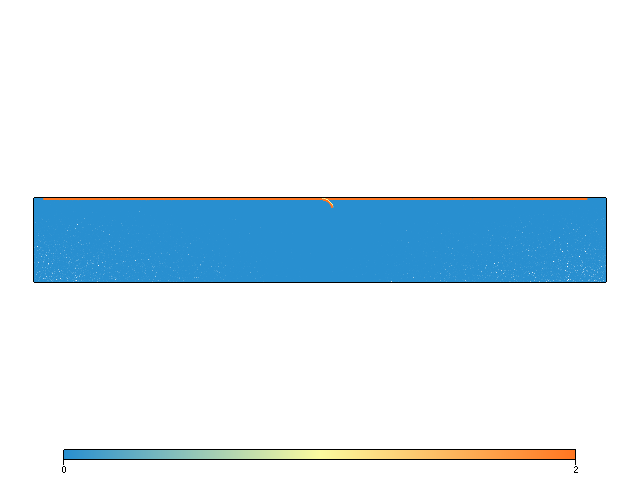

'test.gldb'

In [47]:
fig= glucifer.Figure()
fig.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig.append( glucifer.objects.Surface(mesh, corrTempFn))



fig.show()
fig.save_database('test.gldb')

## phase and compositional buoyancy

In [48]:
##############
#Set up phase buoyancy contributions
#the phase function approach of Yuen and Christenson is implemented in the Slippy2 phase_function class 
##############


#olivine
olivinePhase = phase_function.component_phases(name = 'ol', 
                        depths=[410e3,660e3], #depths of phase transitions along adiabat
                        temps = [1600., 1900.], #temperatures of phase transitions along adiabat
                        widths = [20e3, 20e3], #width if transition
                        claps=[2.e6, -2.5e6],  #Clapeyron slope of trnasition
                        densities = [180., 400.]) #density change of phase transition

olivinePhase.build_nd_dict(dp.LS, dp.rho, dp.g, dp.deltaTa)


rp = olivinePhase.nd_reduced_pressure(depthFn, 
                                   temperatureField,
                                   olivinePhase.ndp['depths'][0],
                                   olivinePhase.ndp['claps'][0],
                                   olivinePhase.ndp['temps'][0])

#ph_410 = olivinePhase.nd_phase(rp, test.ndp['widths'][0])
#pf_sum = test.phase_function_sum(temperatureField, depthFn)

olivine_phase_buoyancy = olivinePhase.buoyancy_sum(temperatureField, depthFn, dp.g, dp.LS, dp.k, dp.eta0)

#garnet
garnetPhase = phase_function.component_phases(name = 'grt', 
                        depths=[60e3,400e3, 720e3],
                        temps = [1000., 1600., 1900.], 
                        widths = [20e3, 20e3, 20e3], 
                        claps=[0.e6, 1.e6, 1.e6], 
                        densities = [350., 150., 400.])

garnetPhase.build_nd_dict(dp.LS, dp.rho, dp.g, dp.deltaTa)


rp = garnetPhase.nd_reduced_pressure(depthFn, 
                                   temperatureField,
                                   garnetPhase.ndp['depths'][0],
                                   garnetPhase.ndp['claps'][0],
                                   garnetPhase.ndp['temps'][0])

#ph_410 = olivinePhase.nd_phase(rp, test.ndp['widths'][0])
#pf_sum = test.phase_function_sum(temperatureField, depthFn)

garnet_phase_buoyancy = garnetPhase.buoyancy_sum(temperatureField, depthFn, dp.g, dp.LS, dp.k, dp.eta0)

In [49]:
##############
#Set up compositional buoyancy contributions
##############

bouyancy_factor = (dp.g*dp.LS**3)/(dp.eta0*dp.k)

basalt_comp_buoyancy  = (dp.rho - 2940.)*bouyancy_factor
harz_comp_buoyancy = (dp.rho - 3235.)*bouyancy_factor
pyrolite_comp_buoyancy = (dp.rho - 3300.)*bouyancy_factor

#print(basalt_comp_buoyancy, harz_comp_buoyancy, pyrolite_comp_buoyancy)


#this function accounts for the decrease in expansivity, and acts to reduce the rayleigh number with depth
alphaRatio = 1.2/3
taFn = 1. - (depthFn)*(1. - alphaRatio) 


if not md.compBuoyancy:
    pyrolitebuoyancyFn =  (ndp.RA*temperatureField*taFn)
    harzbuoyancyFn =      (ndp.RA*temperatureField*taFn) 
    basaltbuoyancyFn =    (ndp.RA*temperatureField*taFn)

else : 
    pyrolitebuoyancyFn =  (ndp.RA*temperatureField*taFn) -\
                          (0.6*olivine_phase_buoyancy + 0.4*garnet_phase_buoyancy) +\
                           pyrolite_comp_buoyancy
    harzbuoyancyFn =      (ndp.RA*temperatureField*taFn) -\
                          (0.8*olivine_phase_buoyancy + 0.2*garnet_phase_buoyancy) +\
                           harz_comp_buoyancy
    basaltbuoyancyFn =    (ndp.RA*temperatureField*taFn) -\
                          (1.*garnet_phase_buoyancy) +\
                           basalt_comp_buoyancy

## Faults / interfaces

In [50]:
import marker2D

In [51]:
def update_swarm_from_faults(faults, proximityVariable, normalVectorVariable, signedDistanceVariable):
    """
    Compute fault attributes from the marker-line objects in the 'faults' list.
    Specifically:
    
      - proximityVariable carries information about which fault each swarm particle is close to (0 means none)
      - normalVectorVariable maps the orientation of the fault to nearby swarm particles
      - signedDistanceVariable carries the distance (positive means 'inside')  
      
      Unchecked error: if these variables are from different swarms 
      
    """
    
    if type(faults) == list:
    
        for fault_seg in faults:
            swarm = proximityVariable.swarm

            f, nz = fault_seg.compute_marker_proximity(swarm.particleCoordinates.data)    
            proximityVariable.data[nz] = f[nz]

            dv, nzv = fault_seg.compute_normals(swarm.particleCoordinates.data)
            normalVectorVariable.data[nzv] = dv[nzv]

            sd, dnz = fault_seg.compute_signed_distance(swarm.particleCoordinates.data)
            signedDistanceVariable.data[dnz] = sd[dnz]
    else:
        fault_seg = faults
        swarm = proximityVariable.swarm

        f, nz = fault_seg.compute_marker_proximity(swarm.particleCoordinates.data)    
        proximityVariable.data[nz] = f[nz]

        dv, nzv = fault_seg.compute_normals(swarm.particleCoordinates.data)
        normalVectorVariable.data[nzv] = dv[nzv]

        sd, dnz = fault_seg.compute_signed_distance(swarm.particleCoordinates.data)
        signedDistanceVariable.data[dnz] = sd[dnz]
    
    return


def update_swarm_from_line(fault, signedDistanceVariable):
    """
    Compute fault attributes from the marker-line objects in the 'faults' list.
    Specifically:
    
      - proximityVariable carries information about which fault each swarm particle is close to (0 means none)
      - normalVectorVariable maps the orientation of the fault to nearby swarm particles
      - signedDistanceVariable carries the distance (positive means 'inside')  
      
      Unchecked error: if these variables are from different swarms 
      
    """
        
    sd, dnz = fault.compute_signed_distance(gSwarm.particleCoordinates.data)
    signedDistanceVariable.data[dnz] = sd[dnz]
    
    return


def mask_materials(fault, material, materialVariable, proximityVariable, normalVectorVariable, signedDistanceVariable):

    """
    set the key fault-related swarm variabels to zero, based on material typr
    """
    
    fptsMask1 = (materialVariable.data[:,0] != material)
    fptsMask2 = (proximityVariable.data[:,0] == fault.ID )

    fptsMaskOut = fptsMask1 & fptsMask2

    normalVectorVariable.data[fptsMaskOut,:] = [0.0,0.0]
    proximityVariable.data[fptsMaskOut] = 0
    signedDistanceVariable.data[fptsMaskOut] = 0.0
    
    
def fault_strainrate_fns(fault_list, velocityField, faultNormalVariable, proximityproVariable):

    ## This is a quick / short cut way to find the resolved stress components.
    
    strainRateFn = fn.tensor.symmetric( velocityField.fn_gradient )

    
    _edotn_SFn = (        directorVector[0]**2 * strainRateFn[0]  + 
                    2.0 * directorVector[1]    * strainRateFn[2] * directorVector[0] + 
                          directorVector[1]**2 * strainRateFn[1]                          
                ) 

    # any non-zero proximity requires the computation of the above
    
    _edotn_SFn_Map    = { 0: 0.0 }
    for f in fault_list:
        _edotn_SFn_Map[f.ID] =  _edotn_SFn



   
    _edots_SFn = (  directorVector[0] *  directorVector[1] *(strainRateFn[1] - strainRateFn[0]) +
                    strainRateFn[2] * (directorVector[0]**2 - directorVector[1]**2)
                 )
    
  
    _edots_SFn_Map = { 0: 1.0e-15 }
    
    for f in fault_list:
        _edots_SFn_Map[f.ID] =  _edots_SFn
        
        
    #Finally, map the resolved strain rate to the proximity variable, 
    #which also makes resolved strain rate zero whereever proximity variable is zero 


    edotn_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edotn_SFn_Map)


    edots_SFn =     fn.branching.map( fn_key = proximityVariable, 
                                      mapping = _edots_SFn_Map )

    
    return edotn_SFn, edots_SFn


## Time update

def faults_advance_in_time(faults,proximityVariable, directorVector, signedDistanceVariable, materialVariable, mmask):
    for f in faults:
        f.advection(dt)


    update_swarm_from_faults(faults, proximityVariable, directorVector, signedDistanceVariable)
    mask_materials(materialV, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

In [52]:
###########
#Initial Coordinates for inerfaces and faults
###########

#subduction fault
introPoint = ndp.subzone - abs(ndp.subzone - ndp.lRidge)/2. #half way between ridge and Sz
faultthickness = ndp.MANTLETOCRUST/2. #initiale fault at half-depth of crust
nfault = 200
faultCoords =np.zeros((nfault, 2))

reducedRocM = ndp.roc  - faultthickness
xlimslab = reducedRocM*math.cos(math.pi*(90. - dp.theta)/180)
faultCoords[:, 0] = np.linspace(introPoint, ndp.subzone + xlimslab, nfault) #note SZ location is hardcoded here 
for index, xval in np.ndenumerate(faultCoords[:,0]):
    #print index, xval
    #swarmCoords[index[0], 1] = 1. - isodepthFn.evaluate((xval, 0.)) #This bit for the plate 
    if  xval < ndp.subzone:
        faultCoords[index[0], 1] = MAXY - faultthickness #This bit for the plate 
        
    else:
        faultCoords[index[0], 1] = (MAXY - (faultthickness) - (reducedRocM - ( math.sqrt((reducedRocM**2 - (xval-ndp.subzone)**2)))))
        
    
faultCoords = faultCoords[faultCoords[:,1] > (MAXY - ndp.maxDepth)] #kill any deeper than cutoff


#surface tracer interface:
surfaceCoords =np.ones((nfault, 2))*1.
surfaceCoords[:,0] = np.linspace(MINX, MAXX, nfault)



#interface that tracks the shape and position of the slab
midthickness = 20e3/dp.LS #initialize tracking swarm at ~ mid lithosphere depth

if dp.sense == 'Right':
    introPoint = ndp.lRidge + midthickness #
else:
    introPoint = ndp.rRidge - midthickness #
nfault = 200
slabCoords =np.zeros((nfault, 2))

reducedRocM = ndp.roc  - midthickness
xlimslab = reducedRocM*math.cos(math.pi*(90. - dp.theta)/180)
slabCoords[:, 0] = np.linspace(introPoint, ndp.subzone + xlimslab, nfault) #note SZ location is hardcoded here 
for index, xval in np.ndenumerate(slabCoords[:,0]):
    #print index, xval
    #swarmCoords[index[0], 1] = 1. - isodepthFn.evaluate((xval, 0.)) #This bit for the plate 
    if  xval < ndp.subzone:
        slabCoords[index[0], 1] = MAXY - midthickness #This bit for the plate 
        
    else:
        slabCoords[index[0], 1] = (MAXY - (midthickness) - (reducedRocM - ( math.sqrt((reducedRocM**2 - (xval-ndp.subzone)**2)))))
        
slabCoords = slabCoords[slabCoords[:,1] > (MAXY - ndp.maxDepth)] #kill any deeper than cutoff


In [53]:
#Initiaze the swarms in a 
fault_seg  = marker2D.markerLine2D(mesh, velocityField, [], [], faultthickness, 0.0, 0.0, crustIndex)
surface_seg  = marker2D.markerLine2D(mesh, velocityField, [], [], ndp.StALS, 0.0, 0.0, airIndex)
slab_seg  = marker2D.markerLine2D(mesh, velocityField, [], [], 1e9/dp.LS, 0.0, 0.0, crustIndex)   #Note very large fault thickness 


#These lists are used to checkpoint the marker lines, similar to the swarm variables.        
interfaces = []
interfaces.append(fault_seg)
interfaces.append(surface_seg)
interfaces.append(slab_seg)
interfacenames = ['fault_seg', 'surface_seg', 'slab_seg']

#If restarting, load the swarms from file Interfaces are just swarms, so should be fine to rely on parallel h5 machinery here
if checkpointLoad:
    for ix in range(len(interfaces)):
        tempname = interfacenames[ix]
        interfaces[ix].swarm.load(os.path.join(checkpointLoadDir,  tempname + ".h5"))

#otherwise add the point from at the initial locations
else:
    fault_seg.add_points(faultCoords[:, 0], faultCoords[:, 1])
    surface_seg.add_points(surfaceCoords[:, 0], surfaceCoords[:, 1])
    slab_seg.add_points(slabCoords[:, 0], slabCoords[:, 1]) 

In [54]:
#Add the necessary swarm variables

proximityVariable      = gSwarm.add_variable( dataType="int", count=1 )
signedDistanceVariable = gSwarm.add_variable( dataType="float", count=1 )
directorVector   = gSwarm.add_variable( dataType="double", count=2)

directorVector.data[:,:] = 0.0
proximityVariable.data[:] = 0
signedDistanceVariable.data[:] = 0.0



# Call the Fault helper functions to initialize this info on the main material swarm
    
update_swarm_from_faults(surface_seg, proximityVariable, directorVector, signedDistanceVariable)
mask_materials(surface_seg, airIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)


update_swarm_from_faults(fault_seg, proximityVariable, directorVector, signedDistanceVariable)
mask_materials(fault_seg, crustIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)

#Also switch off proximity beneath ndp.CRUSTVISCUTOFF depth
proximityVariable.data[gSwarm.particleCoordinates.data[:,1]  < (1. - ndp.CRUSTVISCUTOFF)] = 0. 

# These should be general enough not to need updating when the faults move etc..
#ie they should update as the fields/functions/swarm variables they are built on update
edotn_SFn, edots_SFn = fault_strainrate_fns(interfaces, velocityField, directorVector, proximityVariable)

In [55]:
#Have to add these new swarm variable to our variable lists if we want them to get checkpointed

varlist.append(proximityVariable )
varlist.append(signedDistanceVariable)
varlist.append(directorVector)

varnames.append('proximityVariable')
varnames.append('signedDistanceVariable')
varnames.append('directorVector')


if checkpointLoad:                              #Reload all swarm variables 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.load(os.path.join(checkpointLoadDir,varnames[ix] + ".h5"))
        
 

Rheology
-----



In [56]:
##############
#Set up any functions required by the rheology
##############
strainRate_2ndInvariant = fn.tensor.second_invariant( 
                            fn.tensor.symmetric( 
                            velocityField.fn_gradient ))

def safe_visc(func, viscmin=ndp.eta_min, viscmax=ndp.eta_max):
    return fn.misc.max(viscmin, fn.misc.min(viscmax, func))

In [57]:
#strainRate_2ndInvariant = fn.misc.constant(ndp.SR) #dummy fucntion to check which mechanisms are at active are reference strain rate

In [58]:
##############
#Get dimensional viscosity values at reference values of temp, pressure, and strain rate
##############
dp.rPressure  = dp.rho*dp.g*dp.rDepth
rDf = (1./dp.Adf)*np.exp( ((dp.Edf + dp.Vdf*dp.rPressure))/((dp.R*dp.rTemp)))
rLm = (1./dp.Alm)*np.exp( ((dp.Elm + dp.Vlm*dp.rPressure))/((dp.R*dp.rTemp)))

rDs = (1./dp.Ads**(1./ndp.n))*(dp.SR**((1.-ndp.n)/ndp.n))*np.exp( ((dp.Eds + dp.Vds*dp.rPressure))/((ndp.n*dp.R*dp.rTemp)))
rPr = (1./dp.Apr**(1./ndp.np))*(dp.SR**((1.-ndp.np)/ndp.np))*np.exp( ((dp.Epr + dp.Vpr*dp.rPressure))/((ndp.np*dp.R*dp.rTemp)))

dsfac = rDs/dp.eta0
dffac = rDf/dp.eta0
prfac = rPr/dp.eta0
lmfac = rLm/dp.eta0

In [59]:
#print(dsfac, dffac, prfac, lmfac)

In [60]:
#These guys are legacy - to be fixed

corrDepthFn = depthFn
correctrDepth = ndp.rDepth
corrTempFn = temperatureField

    


In [61]:
############
#Rheology: create UW2 functions for all viscous mechanisms
#############

omega = fn.misc.constant(1.) #this function can hold any arbitary viscosity modifications 


##Diffusion Creep
diffusion = dffac*fn.math.exp( ((ndp.Edf + (corrDepthFn*ndp.Wdf))/((corrTempFn+ ndp.TS))) - 
              ((ndp.Edf + (correctrDepth*ndp.Wdf))/((ndp.rTemp + ndp.TS)))  ) 


##Diffusion Creep
lmdiffusion = lmfac*fn.math.exp( ((ndp.Elm + (corrDepthFn*ndp.Wlm))/((corrTempFn+ ndp.TS))) - 
              ((ndp.Elm + (correctrDepth*ndp.Wlm))/((ndp.rTemp + ndp.TS)))  ) 


linearVisc = safe_visc(diffusion)

##Dislocation Creep
nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.n)/(ndp.n))
dislocation = dsfac*(nl_correction)*fn.math.exp( ((ndp.Eds + (corrDepthFn*ndp.Wds))/(ndp.n*(corrTempFn + ndp.TS))) -
                                     ((ndp.Eds + (correctrDepth*ndp.Wds))/(ndp.n*(ndp.rTemp + ndp.TS))))



##Peirls Creep
nl_correction = (strainRate_2ndInvariant/ndp.SR)**((1.-ndp.np)/(ndp.np))

peierls = prfac*(nl_correction)*fn.math.exp( ((ndp.Eps + (corrDepthFn*ndp.Wps))/(ndp.np*(corrTempFn+ ndp.TS))) -
                                     ((ndp.Eps + (correctrDepth*ndp.Wps))/(ndp.np*(ndp.rTemp + ndp.TS))))


##Define the mantle Plasticity
ys =  ndp.cm + (depthFn*ndp.fcmd)
ysMax = 1e4*1e6*sf.stress
ysf = fn.misc.min(ys, ysMax)
yielding = (math.sqrt(1.0)*ysf)/(2.*(strainRate_2ndInvariant)) #sqrt(0.5) converts for second invariant form in uw2

##Crust rheology
crustys =  ndp.cc + (depthFn*ndp.fccd)
crustysf = fn.misc.min(crustys, ysMax)
crustyielding = (math.sqrt(1.0)*crustysf)/(2.*(strainRate_2ndInvariant)) 


##Interface rheology
interfaceys =  ndp.ci + (depthFn*ndp.fcid) #only weakened cohesion is discussed, not fc
crustysf = fn.misc.min(interfaceys, ysMax)
interfaceyielding = interfaceys/(2.*(strainRate_2ndInvariant))


In [62]:
#(dp.cohesion+ dp.fc*(3300.*9.8*dp.LS))/1e10, (ndp.cohesion + (1.*ndp.fcd))/(1e10*sf.stress)

In [63]:
############
#Rheology: combine viscous mechanisms in various ways 
#harmonic: harmonic average of all mechanims
#min: minimum effective viscosity of the mechanims
#mixed: takes the minimum of the harmonic and the plastic effective viscosity
#############

#Map viscMechs list (defined in setup), to the actual functions, requires that same names are used.
viscdict = {}
for i in md.viscMechs:
    viscdict[i] = locals()[i]

#Condition for weak crust rheology to be active
interfaceCond = operator.and_((depthFn < ndp.CRUSTVISCUTOFF), (depthFn > ndp.MANTLETOCRUST))    
    
#Harmonic average of all mechanisms    
if md.viscCombine == 'harmonic':
    denom = fn.misc.constant(0.)
    for mech in viscdict.values():
        denom += 1./mech
    mantleviscosityFn = safe_visc(1./denom)
    harmonic_test = mantleviscosityFn
    #Only diffusuion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < ndp.LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])

    #Add the weaker crust mechanism, plus any cutoffs
    crust_denom = denom + (1./crustyielding)
    crustviscosityFn = safe_visc(1./crust_denom, viscmin=ndp.eta_min_crust, viscmax=ndp.eta_max_crust)
    #Add the subduction interface mechanism, plus any cutoffs
    interface_denom = denom + (1./interfaceyielding)
    interfaceviscosityFn = safe_visc(1./interface_denom, viscmin=ndp.eta_min_interface, viscmax=ndp.eta_max_interface)
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < ndp.MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interfaceviscosityFn), #
                                                     (True, finalviscosityFn)])

    
    
if md.viscCombine == 'min':
    mantleviscosityFn = fn.misc.constant(ndp.eta_max)
    for mech in viscdict.values():
        mantleviscosityFn = fn.misc.min(mech, mantleviscosityFn )
    mantleviscosityFn = safe_visc(mantleviscosityFn)
    min_test = mantleviscosityFn
    #Only diffusion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < ndp.LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])
    #Add the weaker crust and interface mechanisms, plus any cutoffs
    crustviscosityFn = safe_visc(fn.misc.min(finalviscosityFn, crustyielding), viscmin=ndp.eta_min_crust, viscmax=ndp.eta_max_crust)
    interfaceviscosityFn = safe_visc(fn.misc.min(finalviscosityFn, interfaceyielding), viscmin=ndp.eta_min_interface, viscmax=ndp.eta_max_interface)
    #Crust viscosity only active above CRUSTVISCUTOFF
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < ndp.MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interfaceviscosityFn), #
                                                     (True, finalviscosityFn)])

if md.viscCombine == 'mixed':
    denom = fn.misc.constant(0.)
    for mech in viscdict.values():
        denom += 1./mech
    mantleviscosityFn = safe_visc(fn.misc.min(yielding, (1./denom))) #min of harmonic average and yielding
    mixed_test = mantleviscosityFn
    #Only diffusuion creep for lower mantle
    finalviscosityFn  = fn.branching.conditional([(depthFn < LOWMANTLEDEPTH, mantleviscosityFn),
                                  (True, safe_visc(lmdiffusion*ndp.low_mantle_visc_fac))])
    
    #Add the weaker crust mechanism, plus any cutoffs
    crust_denom = denom + (1./crustyielding)
    crustviscosityFn = safe_visc(fn.misc.min(crustyielding,1./crust_denom), viscmin=ndp.eta_min_crust, viscmax=ndp.eta_max_crust)

    interface_denom = denom + (1./interfaceyielding)
    interfaceviscosityFn = safe_visc(fn.misc.min(interfaceyielding,1./interface_denom), viscmin=ndp.eta_min_interface, viscmax=ndp.eta_max_interface)
    #Crust viscosity only active above between CRUSTVISCUTOFF and MANTLETOCRUST
    finalcrustviscosityFn  = fn.branching.conditional([(depthFn < MANTLETOCRUST, crustviscosityFn),
                                                     (interfaceCond, interfaceviscosityFn), #
                                                     (True, finalviscosityFn)])
    



In [64]:
#ndp.low_mantle_visc_fac = 1.


In [65]:
#viscMinConditions = fn.misc.min(diffusion, dislocation, peierls, yielding)

viscMin = fn.misc.constant(ndp.eta_max)
#Generate the minimum viscosity function 
for mech in [safe_visc(diffusion), safe_visc(dislocation), safe_visc(peierls), safe_visc(yielding)]:
    viscMin = fn.misc.min(mech, viscMin) 
    
dm = 1e-5
   
    
viscMinConditions = [ ( operator.and_((viscMin > (ndp.eta_max - dm) ),
                           (viscMin < (ndp.eta_max + dm) ))  , 0),  #visc = ndp.eta_max
                      ( operator.and_((viscMin > (diffusion - dm) ),
                           (viscMin < (diffusion + dm) ))  , 1),  #visc = diffusion
                      ( operator.and_((viscMin > (dislocation - dm) ),
                           (viscMin < (dislocation + dm) ))  , 2),#visc = dislocation
                      ( operator.and_((viscMin > (peierls - dm) ),
                           (viscMin < (peierls + dm) ))  , 3),    #visc = peierls
                      ( operator.and_((viscMin > (yielding - dm) ),
                           (viscMin < (yielding + dm) ))  , 4),   #visc = yielding
                      ( True                                           , 5) ] #visc = eta_min (should be)




# use the branching conditional function to set each particle's index
fnViscMin = fn.branching.conditional( viscMinConditions )



In [66]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,finalviscosityFn, logScale=True))
#fig.show()
#fig.save_database('test.gldb')

In [67]:
#fig.save_database('test.gldb')

Stokes system setup
-----


In [68]:
densityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {airIndex:ndp.StRA,
                                    crustIndex:basaltbuoyancyFn, 
                                    mantleIndex:pyrolitebuoyancyFn,
                                    harzIndex:harzbuoyancyFn} )

In [69]:

# Define our vertical unit vector using a python tuple (this will be automatically converted to a function).
gravity = ( 0.0, 1.0 )

# Now create a buoyancy force vector using the density and the vertical unit vector. 
buoyancyFn = densityMapFn * gravity

In [70]:
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=linearVisc, 
                              fn_bodyforce=buoyancyFn )

In [71]:
solver = uw.systems.Solver(stokesPIC)
if not checkpointLoad:
    solver.solve() #A solve on the linear visocisty is unhelpful unless we're starting from scratch

In [72]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,materialVariable))
#fig.append( glucifer.objects.Surface(mesh, finalviscosityFn, logScale=True))

#fig.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant/ndp.SR, logScale=True))
#fig.show()
#fig.save_database('test.gldb')

In [73]:
viscosityMapFn = fn.branching.map( fn_key = materialVariable,
                         mapping = {crustIndex:finalcrustviscosityFn,
                                    mantleIndex:finalviscosityFn,
                                    harzIndex:finalviscosityFn} )



import matplotlib.pylab as pyplt
%matplotlib inline



##################
#Output functions to numpy vertical averages, maxes, mins
##################

viscmapFnmesh = uw.mesh.MeshVariable(mesh,nodeDofCount=1)
out = uw.utils.MeshVariable_Projection( viscmapFnmesh, viscosityMapFn)
out.solve()


#avDf = ndfp.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)
avDs = ndsp.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)
umantle = mantleviscosityFn.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)
lmantle = lowermantleviscosityFn.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)
eff = viscmapFnmesh.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).mean(axis=1)

effMin = viscmapFnmesh.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).min(axis=1)
effMax = viscmapFnmesh.evaluate(mesh).reshape(mesh.elementRes[1] + 1, mesh.elementRes[0] + 1).max(axis=1)

###################
#Plot
###################
import matplotlib.pylab as pyplt
%matplotlib inline

fig, ax = pyplt.subplots()
#ax .plot(avDf, label = 'diff')
#ax .plot(avDs, label = 'dis')
ax .plot(eff, label = 'eff')
ax .plot(effMax, label = 'effMax')
ax .plot(effMin, label = 'effMin')
#ax .plot(umantle, label = 'uman')
#ax .plot(lmantle, label = 'lman')
ax.set_yscale("log", nonposy='clip')
ax.legend(loc = 3)

In [74]:
#Add the non-linear viscosity to the Stokes system
stokesPIC.fn_viscosity = viscosityMapFn

In [75]:
solver.set_inner_method("mumps")
solver.options.scr.ksp_type="cg"
solver.set_penalty(1.0e7)
solver.options.scr.ksp_rtol = 1.0e-4
solver.solve(nonLinearIterate=True)
solver.print_stats()


 
Pressure iterations:   3
Velocity iterations:   1 (presolve)      
Velocity iterations:  -1 (pressure solve)
Velocity iterations:   1 (backsolve)     
Velocity iterations:   1 (total solve)   
 
SCR RHS  solve time: 9.0853e-01
Pressure solve time: 1.1831e-01
Velocity solve time: 8.9038e-01 (backsolve)
Total solve time   : 2.0860e+00
 
Velocity solution min/max: 0.0000e+00/0.0000e+00
Pressure solution min/max: 0.0000e+00/0.0000e+00
 



In [76]:
#Check which particles are yielding
#yieldingCheck.data[:] = 0

#yieldconditions = [ ( mantleviscosityFn < Visc , 1), 
#               ( True                                           , 0) ]

# use the branching conditional function to set each particle's index
#yieldingCheck.data[:] = fn.branching.conditional( yieldconditions ).evaluate(gSwarm)

In [77]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,yieldingCheck))

#fig.append( glucifer.objects.Surface(mesh,ndflm, logScale=True))
#fig.show()

Advection-diffusion System setup
-----

In [78]:
advDiff = uw.systems.AdvectionDiffusion( phiField       = temperatureField, 
                                         phiDotField    = temperatureDotField, 
                                         velocityField  = velocityField,
                                         fn_sourceTerm    = 0.0,
                                         fn_diffusivity = 1.0, 
                                         #conditions     = [neumannTempBC, dirichTempBC] )
                                         conditions     = [ dirichTempBC] )

materialadvector = uw.systems.SwarmAdvector( swarm         = gSwarm, 
                                     velocityField = velocityField, 
                                     order         = 1)

In [79]:
population_control = uw.swarm.PopulationControl(gSwarm,deleteThreshold=0.2,splitThreshold=1.,maxDeletions=3,maxSplits=0, aggressive=True, particlesPerCell=md.ppc)

############
#Slightly Diffuse the initial perturbation
#############

#I was playing around with a tailored diffusivity to target the slab

inCircleFnGenerator#Now build the perturbation part
def htan(centre, radius, widthPh, farVal = 0.01, fac = 10.):
    coord = fn.input()
    offsetFn = coord - centre
    dist = fn.math.sqrt(fn.math.dot( offsetFn, offsetFn ))
    
    
    return (((fn.math.tanh(((radius - dist))/widthPh) + 1.) /2.))*fac + farVal

tfun = htan((0.1, 0.9), 0.1, 0.1, 0.1)

for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 

timetoDifffuse = 0.#Million years
incrementtoDiffuse = 0.2 #Million years

timetoDifffuse = (timetoDifffuse*1e6*(spery)/sf.SR).magnitude
incrementtoDiffuse = (incrementtoDiffuse*1e6*(spery)/sf.SR).magnitude

totAdt = 0.
it = 0
while totAdt < timetoDifffuse:
    dtad = advDiff.get_max_dt()
    print("step") + str(it) 
    advDiff.integrate(incrementtoDiffuse)
    totAdt += incrementtoDiffuse
    it += 1
    
#Reset Boundary conds.   
for index in mesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = ndp.TBP
for index in mesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = ndp.TSP
    
comm.Barrier()

Analysis functions / routines
-----

Most of the metrics we want to calculate are either:

* extrema of some field / function
* integral of some field / function
* average value of some function (integral divide by area)

In addition, we also want to be able to determine these metrics over some restricted part of the domain, where the restriction may either be due some value of a field, a material type, or something more arbitrary.

Much of he challenge lies in defining these restriction functions in an efficient and robust way (i.e they don't break down as the model evolves)

For volume integrals, and extrema, we build a hierarchy of restriction functions, each borrowing from the previous, until we have divided the domain into a number of sub regions of interest. 

In general, averages are found afterwards by combining the integral and the area of the relavent subregion

In [80]:
###################
#Volume Restriction functions
###################

#Level 1. Global
globRestFn = fn.misc.constant(1.)

#Level 2. Rock - air:
rockRestFn = uw.swarm.SwarmVariable(gSwarm, dataType='double', count=1)
rockRestFn.data[:] = 0.
rockRestFn.data[np.where(materialVariable.data[:] != airIndex)] = 1.
rockRestFn *= globRestFn #Add next level up in heirarchy


#Level 3. lithosphere - mantle:
tempMM = fn.view.min_max(temperatureField)
tempMM.evaluate(mesh)
TMAX = tempMM.max_global()
mantleconditions = [ (                                  temperatureField < 0.9*TMAX, 1.),
                   (                                                   True , 0.) ]
lithRestFn = fn.branching.conditional(mantleconditions)
lithRestFn*=rockRestFn #Add next level up in heirarchy


#Level 4. lower plate - upper plate:


#This whole section simply builds a restriction Fn that separates the upper and lower plate 
#It's pretty cumbersome, and will need to advected, rebuilt
#can YOU think of a better way?
   
lowerPlateRestFn = gSwarm.add_variable( dataType="double", count=1 )
lowerPlateRestFn.data[:] = 0.0

update_swarm_from_line(slab_seg, lowerPlateRestFn )
lowerPlateRestFn.data[np.where(lowerPlateRestFn.data != 0.)] += midthickness #assume instances of 0. are actually where no fault on proc
lowerPlateRestFn.data[np.where(lowerPlateRestFn.data > 0.*midthickness)] = 1.
lowerPlateRestFn.data[np.where(lowerPlateRestFn.data <= 0.*midthickness)] = 0. 
lowerPlateRestFn *= lithRestFn #Add next level up in heirarchy

#Also see if we can stick the the Velocity and coords on to this swarm as well
tipVar = uw.swarm.SwarmVariable(slab_seg.swarm, dataType='double', count=4)
tipVar.data[:,:2] = velocityField.evaluate(slab_seg.swarm)
tipVar.data[:,2:] = xFn.evaluate(slab_seg.swarm)
tipVar.data[:,3:] = yFn.evaluate(slab_seg.swarm)


#Level 5. hinge of lower plate:

hinge60Spatialconditions = [ (           operator.and_( (depthFn < (60e3/dp.LS)),  (xFn > ndp.subzone - 60e3/dp.LS)), 1.),
                   (                                                   True , 0.) ]

hinge60RestFn = fn.branching.conditional(hinge60Spatialconditions)
hinge60RestFn*=lowerPlateRestFn #Add next level up in heirarchy



hinge180Spatialconditions = [ (           operator.and_( (depthFn < (180e3/dp.LS)),  (xFn > ndp.subzone - 180e3/dp.LS)), 1.),
                   (                                                   True , 0.) ]

hinge180RestFn = fn.branching.conditional(hinge180Spatialconditions)
hinge180RestFn*=lowerPlateRestFn #Add next level up in heirarchy


#Level 6. crust/interface in hinge of lower plate:

interfaceRestFn = uw.swarm.SwarmVariable(gSwarm, dataType='double', count=1)
interfaceRestFn.data[:] = 0.
interfaceRestFn.data[np.where(materialVariable.data[:] == crustIndex)] = 1.
interfaceRestFn *= hinge60RestFn #Add next level up in heirarchy

In [81]:
respltconditions = [ 
                    (                                  hinge60RestFn*2. > rockRestFn*1., 1.),
                    (                                  lowerPlateRestFn*3. > hinge60RestFn*2. , 3.),
                    (                                  lithRestFn*5. > lowerPlateRestFn*3. , 4.),
                   (                                                   True , 0.) ]

respltFn = fn.branching.conditional(respltconditions )

In [82]:
###################
#Surface Restriction functions
###################

def platenessFn(val = 0.1):
    normgradV = fn.math.abs(velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])) #[du*/dx]/sqrt(u*u)



    srconditions = [ (                                  normgradV < val, 1.),
                   (                                                   True , 0.) ]


    return fn.branching.conditional(srconditions)

srRestFn = platenessFn(val = 0.1)

In [83]:
###################
#Setup any Functions to be integrated
###################

sqrtv2 = fn.math.sqrt(fn.math.dot(velocityField,velocityField))
vx = velocityField[0]
v2x = fn.math.dot(velocityField[0],velocityField[0])
sqrtv2x = fn.math.sqrt(fn.math.dot(velocityField[0],velocityField[0]))
dw = temperatureField*velocityField[1]
sinner = fn.math.dot( strainRate_2ndInvariant, strainRate_2ndInvariant )
vd = 2.*viscosityMapFn*sinner
dTdZ = temperatureField.fn_gradient[1]

In [84]:
###################
#Create integral, max/min templates 
###################

def volumeint(Fn = 1., rFn=globRestFn):
    return uw.utils.Integral( Fn*rFn,  mesh )

def surfint(Fn = 1., rFn=globRestFn, surfaceIndexSet=mesh.specialSets["MaxJ_VertexSet"]):
    return uw.utils.Integral( Fn*rFn, mesh=mesh, integrationType='Surface', surfaceIndexSet=surfaceIndexSet)

def maxMin(Fn = 1.):
    #maxMin(Fn = 1., rFn=globRestFn
    #vuFn = fn.view.min_max(Fn*rFn) #the restriction functions don't work with the view.min_max fn yet
    vuFn = fn.view.min_max(Fn)
    return vuFn
    

In [85]:
#Setup volume integrals on different sub regions

##Whole rock domain

_areaintRock = volumeint(rockRestFn)
_tempintRock = volumeint(temperatureField, rockRestFn)
_rmsintRock = volumeint(sqrtv2,rockRestFn)
_dwintRock = volumeint(dw,rockRestFn)
_vdintRock = volumeint(vd,rockRestFn)

##Lith 

_areaintLith  = volumeint(lithRestFn)
_tempintLith  = volumeint(temperatureField, lithRestFn)
_rmsintLith  = volumeint(sqrtv2,lithRestFn)
_dwintLith  = volumeint(dw,lithRestFn)
_vdintLith  = volumeint(vd,lithRestFn)

##Lower plate

_areaintLower  = volumeint(lowerPlateRestFn)
_tempintLower  = volumeint(temperatureField, lowerPlateRestFn)
_rmsintLower  = volumeint(sqrtv2,lowerPlateRestFn)
_dwintLower = volumeint(dw,lowerPlateRestFn)
_vdintLower  = volumeint(vd,lowerPlateRestFn)

##Hinge lower plate

_areaintHinge180  = volumeint(hinge180RestFn)
_vdintHinge180  = volumeint(vd,hinge180RestFn)

_areaintHinge60  = volumeint(hinge60RestFn)
_vdintHinge60  = volumeint(vd,hinge60RestFn)


##Interface

_areaintInterface  = volumeint(interfaceRestFn)
_vdintInterface = volumeint(vd,interfaceRestFn)

In [86]:
#Setup surface integrals

_surfLength = surfint()
_rmsSurf = surfint(v2x)
_nuTop = surfint(dTdZ)
_nuBottom = surfint(dTdZ, surfaceIndexSet=mesh.specialSets["MinJ_VertexSet"])
_plateness = surfint(srRestFn)

In [87]:
#Setup max min fns (at the moment, we can't pass restriction function to view.min_max, so we're limited to whole volume or surface extrema)

##Whole rock domain

#_maxMinVisc = maxMin(viscosityMapFn1)  #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinVisc.evaluate(mesh)
#_maxMinStressInv = maxMin(2*viscosityMapFn1*strainRate_2ndInvariant) #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinStress.evaluate(mesh)
#_maxMinVd = maxMin(vd) #These don't work on swarm variables or mapping functions, yet
#dummyFn = _maxMinVd.evaluate(mesh)


_maxMinVel = maxMin(velocityField) 
dummyFn = _maxMinVel.evaluate(mesh)

_maxMinSr = maxMin(strainRate_2ndInvariant) 
dummyFn = _maxMinSr.evaluate(mesh)


#Surface extrema
_maxMinVxSurf = maxMin(vx)
dummyFn = _maxMinVxSurf.evaluate(tWalls)


In [88]:
#Volume Ints
areaintRock = _areaintRock.evaluate()[0]
tempintRock = _tempintRock.evaluate()[0]
rmsintRock = _rmsintRock.evaluate()[0]
dwintRock = _dwintRock.evaluate()[0]
vdintRock = _vdintRock.evaluate()[0]
areaintLith = _areaintLith.evaluate()[0]
tempintLith = _tempintLith.evaluate()[0]
rmsintLith = _rmsintLith.evaluate()[0]
dwintLith = _dwintLith.evaluate()[0]
vdintLith = _vdintLith.evaluate()[0]
areaintLower = _areaintLower.evaluate()[0]
tempintLower = _tempintLower.evaluate()[0]
rmsintLower = _rmsintLower.evaluate()[0]
dwintLower = _dwintLower.evaluate()[0]
vdintLower = _vdintLower.evaluate()[0]
vdintHinge180 = _vdintHinge180.evaluate()[0]
areaintHinge180 = _areaintHinge180.evaluate()[0]
vdintHinge60 = _vdintHinge60.evaluate()[0]
areaintHinge60= _areaintHinge60.evaluate()[0]
vdintInterface = _vdintInterface.evaluate()[0]
areaintInterface= _areaintInterface.evaluate()[0]

#Surface Ints
surfLength = _surfLength.evaluate()[0]
rmsSurf = _rmsSurf.evaluate()[0]
nuTop = _nuTop.evaluate()[0]
nuBottom = _nuBottom.evaluate()[0]
plateness = _plateness.evaluate()[0]

#Max mins
maxVel = _maxMinVel.max_global()
minVel = _maxMinVel.min_global() 
maxSr = _maxMinSr.max_global()
minSr = _maxMinSr.min_global()
maxVxsurf = _maxMinVxSurf.max_global()
minVxsurf = _maxMinVxSurf.min_global()

print(areaintRock)
print(tempintRock)
print(rmsintRock)
print(dwintRock)
print(vdintRock)
print(areaintLith)
print(tempintLith )
print(rmsintLith)
print(dwintLith)
print(vdintLith)
print(areaintLower)
print(tempintLower)
print(rmsintLower) 
print(dwintLower)
print(vdintLower)
print(vdintHinge60)
print(vdintHinge180)
print(vdintInterface)

print(surfLength)
print(rmsSurf)
print(nuTop)
print(nuBottom)
print(plateness)


print(maxVel)
print(minVel)
print(maxSr)
print(minSr)
print(maxVxsurf)
print(minVxsurf)

Viz.
-----

In [89]:
if figures == 'gldb':
    #Pack some stuff into a database as well
    figDb = glucifer.Figure()
    #figDb.append( glucifer.objects.Mesh(mesh))
    figDb.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))
    #figDb.append( glucifer.objects.Points(gSwarm,tracerVariable, colours= 'white black'))
    figDb.append( glucifer.objects.Points(gSwarm,materialVariable))
    #figDb.append( glucifer.objects.Points(gSwarm,viscMinVariable))
    #figDb.append( glucifer.objects.Points(gSwarm,fnViscMin))
    figDb.append( glucifer.objects.Points(gSwarm,fnViscMin))
    figDb.append( glucifer.objects.Points(gSwarm, viscosityMapFn, logScale=True))
    figDb.append( glucifer.objects.Points(gSwarm, strainRate_2ndInvariant, logScale=True))
    figDb.append( glucifer.objects.Points(gSwarm,temperatureField))
    
    
    figRestrict= glucifer.Figure()
    #figRestrict.append( glucifer.objects.Points(gSwarm,respltFn))
    figRestrict.append( glucifer.objects.Points(gSwarm,lithRestFn))
    figRestrict.append( glucifer.objects.Points(gSwarm,lowerPlateRestFn))
    figRestrict.append( glucifer.objects.Points(gSwarm,hinge180RestFn))
    figRestrict.append( glucifer.objects.Points(gSwarm,interfaceRestFn))
    figRestrict.append( glucifer.objects.Points(interfaces[0].swarm, colours="Blue Blue", pointSize=2.0, colourBar=False) )
    figRestrict.append( glucifer.objects.Points(interfaces[1].swarm, colours="Red Red", pointSize=2.0, colourBar=False) )
    figRestrict.append( glucifer.objects.Points(slab_seg.swarm, colours="Black Black", pointSize=2.0, colourBar=False) )

elif figures == 'store':
    fullpath = os.path.join(outputPath + "gldbs/")
    store = glucifer.Store(fullpath + 'subduction.gldb')

    figTemp = glucifer.Figure(store,figsize=(300*np.round(md.aspectRatio,2),300))
    figTemp.append( glucifer.objects.Points(gSwarm,temperatureField))

    figVisc= glucifer.Figure(store, figsize=(300*np.round(md.aspectRatio,2),300))
    figVisc.append( glucifer.objects.Points(gSwarm,viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))
    
    figSr= glucifer.Figure(store, figsize=(300*np.round(md.aspectRatio,2),300))
    figSr.append( glucifer.objects.Points(gSwarm,strainRate_2ndInvariant, logScale=True))
    figSr.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.0005))

    #figMech= glucifer.Figure(store, figsize=(300*np.round(md.aspectRatio,2),300))
    #figMech.append( glucifer.objects.Points(gSwarm,fnViscMin))

**Miscellania**

In [90]:
##############
#Create a numpy array at the surface to get surface information on (using parallel-friendly evaluate_global)
##############

surface_xs = np.linspace(mesh.minCoord[0], mesh.maxCoord[0], mesh.elementRes[0] + 1)
surface_nodes = np.array(zip(surface_xs, np.ones(len(surface_xs)*mesh.maxCoord[1]))) #For evaluation surface velocity
normgradV = velocityField.fn_gradient[0]/fn.math.sqrt(velocityField[0]*velocityField[0])

tempMM = fn.view.min_max(temperatureField)
dummy = tempMM.evaluate(mesh)



/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:190: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  a = empty(shape, dtype, order)


In [91]:
#Not parallel friendly yet
#tipXvels = np.sum(velocityField[0].evaluate(tipSwarm)) /\
#    tipSwarm.particleGlobalCount
#tipXvels = np.sum(velocityField[1].evaluate(tipSwarm)) /\
#    tipSwarm.particleGlobalCount
    
#tipXpos = np.sum(xFn.evaluate(tipSwarm)) /\
#    tipSwarm.particleGlobalCount
#tipYpos = np.sum(yFn.evaluate(tipSwarm)) /\
#    tipSwarm.particleGlobalCount

In [114]:
##############
#These functions handle checkpointing
##############


#Subzone = ndp.subzone


def checkpoint1(step, checkpointPath,filename, filewrites):
    path = checkpointPath + str(step) 
    os.mkdir(path)
    ##Write and save the file, if not already a writing step
    if not step % filewrites == 0:
        f_o.write((28*'%-15s ' + '\n') % (areaintRock, tempintRock, rmsintRock, dwintRock, vdintRock,
                                  areaintLith, tempintLith,rmsintLith, dwintLith, vdintLith,
                                  areaintLower, tempintLower, rmsintLower, dwintLower, vdintLower, 
                                  areaintHinge180,vdintHinge180, areaintHinge60, vdintHinge60, 
                                  areaintInterface, vdintInterface, vdintInterface,
                                  rmsSurf, nuTop, nuBottom, plateness, ndp.subzone, realtime))
    filename.close()
    shutil.copyfile(os.path.join(outputPath, outputFile), os.path.join(path, outputFile))


def checkpoint2(step, checkpointPath, swarm, filename, varlist = [materialVariable], varnames = ['materialVariable']):
    path = checkpointPath + str(step) 
    velfile = "velocityField" + ".hdf5"
    tempfile = "temperatureField" + ".hdf5"
    pressfile = "pressureField" + ".hdf5"
    velocityField.save(os.path.join(path, velfile))
    temperatureField.save(os.path.join(path, tempfile))
    pressureField.save(os.path.join(path, pressfile))
    swarm.save(os.path.join(path, "swarm.h5") ) 
    for ix in range(len(varlist)):
        varb = varlist[ix]
        varb.save(os.path.join(path,varnames[ix] + ".h5"))
    
    #Save the parameters
    dict_list = [dp, sf, ndp, md] #if any of the dictionaries have changed, this list needs to be rebuilt
    save_pickles(dict_list, dict_names, path)
    
#Simple Checkpoint function for the faults / interfaces (markerLine2D)
def checkpoint3(step,  checkpointPath, interfaces,interfacenames ):
    path = checkpointPath + str(step)
    for ix in range(len(interfaces)):
        intf = interfaces[ix]
        intf.swarm.save(os.path.join(path,interfacenames[ix] + ".h5"))
    
    

In [115]:
##############
#Simple function to return info about location of plate boundaries
##############

def getnearpos(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx 

def plate_info(srfilename, minx, maxx,  searchdx, oldszloc = 0.0):
    """
    Use the surface strain rate field to find the location of the subduction zone in 2d
    
    """
    if type(srfilename) == str: #read surface strain rate points from file
        sr = np.load(srfilename)
    else:
        sr =  srfilename        #read surface strain rates directly from array
    xs = np.linspace(minx,maxx,sr.shape[0] )
    #infs at the ends of the SR data...replace with adjacent values
    sr[0] = sr[1] 
    sr[-1] = sr[2]
    #Normalize
    srx = (sr- sr.mean()) /(sr.max() - sr.min())
    #reduce the search domain, to near the previous PB location
    lx, rx = getnearpos(xs, oldszloc - searchdx),  getnearpos(xs, oldszloc + searchdx)
    red_xs, red_sr = xs[lx:rx], srx[lx:rx]
    #return the minima
    newszLoc = red_xs[np.argmin(red_sr)]
    return newszLoc 

In [116]:
##############
#This will allow us to evaluate viscous shear heating, and add the result directly to the temperature field
##############

viscDisMapFn = 2.*viscosityMapFn*sinner
viscDisFnmesh = uw.mesh.MeshVariable(mesh,nodeDofCount=1)
viscDisProj = uw.utils.MeshVariable_Projection( viscDisFnmesh, viscDisMapFn)
viscDisProj.solve()

In [117]:
# initialise timer for computation
start = time.clock()


Main simulation loop
-----


In [ ]:
#while step < 21:
while realtime < 1.:

    # solve Stokes and advection systems
    solver.solve(nonLinearIterate=True)
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    advDiff.integrate(dt)
    materialadvector.integrate(dt)
    for f in interfaces:
        f.advection(dt)
    
    #Add the adiabatic adjustment 
    temperatureField.data[:] += dt*abHeatFn.evaluate(mesh)
    
    #Add the viscous heating term
    #Need to fix this (forgot 'dissipation number')
    #viscDisProj = uw.utils.MeshVariable_Projection( viscDisFnmesh, viscDisMapFn)
    #viscDisProj.solve()
    #temperatureField.data[:] += dt*viscDisFnmesh.evaluate(mesh)
    

    # Increment
    realtime += dt
    step += 1
    timevals.append(realtime)
    ################
    #Update temperature field in the air region
    #Do this better...
    ################
    if (step % sticky_air_temp == 0):
        for index, coord in enumerate(mesh.data):
            if coord[1] >= 1.:
                temperatureField.data[index] = ndp.TSP

    ################
    # Calculate the Metrics
    ################
    if (step % metric_output == 0):
        ###############
        #Rebuild the restriction functions where necessary
        ###############
        lowerPlateRestFn = gSwarm.add_variable( dataType="double", count=1 )
        lowerPlateRestFn.data[:] = 0.0
        update_swarm_from_line(slab_seg, lowerPlateRestFn )
        lowerPlateRestFn.data[np.where(lowerPlateRestFn.data >= -1.*midthickness)] = 1.
        lowerPlateRestFn.data[np.where(lowerPlateRestFn.data < -1.*midthickness)] = 0. 
        lowerPlateRestFn *= lithRestFn #Add next level up in hierarchy
        
        #Hinge
        
        hinge60Spatialconditions = [ (           operator.and_( (depthFn < MAXY - (60e3/dp.LS)),  (xFn > ndp.subzone - 60e3/dp.LS)), 1.),
                   (                                                   True , 0.) ]
        hinge60RestFn = fn.branching.conditional(hinge60Spatialconditions)
        hinge60RestFn*=lowerPlateRestFn #Add next level up in hierarchy



        hinge180Spatialconditions = [ (           operator.and_( (depthFn < MAXY - (180e3/dp.LS)),  (xFn > ndp.subzone - 180e3/dp.LS)), 1.),
                           (                                                   True , 0.) ]
        hinge180RestFn = fn.branching.conditional(hinge180Spatialconditions)
        hinge180RestFn*=lowerPlateRestFn #Add next level up in hierarchy
        
        ###############
        #Metrics
        ###############
        areaintRock = _areaintRock.evaluate()[0] #trivial except when using sticky air
        tempintRock = _tempintRock.evaluate()[0]
        rmsintRock = _rmsintRock.evaluate()[0]
        dwintRock = _dwintRock.evaluate()[0]
        vdintRock = _vdintRock.evaluate()[0]
        areaintLith = _areaintLith.evaluate()[0]
        tempintLith = _tempintLith.evaluate()[0]
        rmsintLith = _rmsintLith.evaluate()[0]
        dwintLith = _dwintLith.evaluate()[0]
        vdintLith = _vdintLith.evaluate()[0]
        areaintLower = _areaintLower.evaluate()[0]
        tempintLower = _tempintLower.evaluate()[0]
        rmsintLower = _rmsintLower.evaluate()[0]
        dwintLower = _dwintLower.evaluate()[0]
        vdintLower = _vdintLower.evaluate()[0]
        vdintHinge180 = _vdintHinge180.evaluate()[0]
        areaintHinge180 = _areaintHinge180.evaluate()[0]
        vdintHinge60 = _vdintHinge60.evaluate()[0]
        areaintHinge60= _areaintHinge60.evaluate()[0]
        vdintInterface = _vdintInterface.evaluate()[0]
        areaintInterface= _areaintInterface.evaluate()[0]
        #Surface integrals
        rmsSurf = _rmsSurf.evaluate()[0]
        nuTop = _nuTop.evaluate()[0]
        nuBottom = _nuBottom.evaluate()[0]
        plateness = _plateness.evaluate()[0]
        #extrema
        maxVel = _maxMinVel.max_global()
        minVel = _maxMinVel.min_global() 
        maxSr = _maxMinSr.max_global()
        minSr = _maxMinSr.min_global()
        maxVxsurf = _maxMinVxSurf.max_global()
        minVxsurf = _maxMinVxSurf.min_global()
        # output to text file...root proc. handles this one
        if uw.rank()==0:
            f_o.write((28*'%-15s ' + '\n') % (areaintRock, tempintRock, rmsintRock, dwintRock, vdintRock,
                                  areaintLith, tempintLith,rmsintLith, dwintLith, vdintLith,
                                  areaintLower, tempintLower, rmsintLower, dwintLower, vdintLower, 
                                  areaintHinge180,vdintHinge180, areaintHinge60, vdintHinge60, 
                                  areaintInterface, vdintInterface, vdintInterface,
                                  rmsSurf, nuTop, nuBottom, plateness, ndp.subzone, realtime))
    ################
    #Also repopulate entire swarm periodically
    ################
    #if step % swarm_repop == 0:
    population_control.repopulate()   

    ################
    #Gldb output
    ################ 
    if (step % gldbs_output == 0): 
        if figures == 'gldb':
            #Remember to rebuild any necessary swarm variables
            fnamedb = "dbFig" + "_" + str(step) + ".gldb"
            fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            figDb.save_database(fullpath)
            
            #Temp figure
            fnamedb = "restrictFig" + "_" + str(step) + ".gldb"
            fullpath = os.path.join(outputPath + "gldbs/" + fnamedb)
            figRestrict.save_database(fullpath)
        elif figures == 'store':      
            fullpath = os.path.join(outputPath + "gldbs/")
            store.step = step
            #Save figures to store
            figVisc.save( fullpath + "Visc" + str(step).zfill(4))
            #figMech.save( fullPath + "Mech" + str(step).zfill(4))
            figTemp.save( fullpath + "Temp"    + str(step).zfill(4))
            figSr.save( fullpath + "Str_rte"    + str(step).zfill(4))
    ################
    #Files output
    ################ 
    if (step % files_output == 0):

        vel_surface = velocityField.evaluate_global(surface_nodes)
        norm_surface_sr = normgradV.evaluate_global(surface_nodes)
        if uw.rank() == 0:
            fnametemp = "velsurface" + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, vel_surface)
            fnametemp = "norm_surface_sr" + "_" + str(step)
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            np.save(fullpath, norm_surface_sr)
            
        #Save the slab_seg and tipswarm coords 
        fnametemp1 = "midSwarm" + "_" + str(step)
        fullpath1 = os.path.join(outputPath + "files/" + fnametemp1)
        slab_seg.swarm.save(fullpath1)
        #tipVar.data[:,:2] = velocityField.evaluate(tipSwarm)
        #tipVar.data[:,2:] = xFn.evaluate(tipSwarm)
        #tipVar.data[:,3:] = yFn.evaluate(tipSwarm)
        #comm.barrier()
        #fnametemp2 = "tipSwarm" + "_" + str(step)
        #fullpath2 = os.path.join(outputPath + "files/" + fnametemp2)
        #tipVar.save('fullpath2')
        
        
    ################
    #Update the subduction zone / plate information
    ################ 
    
    comm.barrier()
    if (step % files_output == 0):
        
        if uw.rank() == 0:
            fnametemp = "norm_surface_sr" + "_" + str(step) + ".npy"
            fullpath = os.path.join(outputPath + "files/" + fnametemp)
            ndp.subzone = plate_info(fullpath, MINX, MAXX,  800e3/dp.LS, oldszloc = ndp.subzone)
            
        else:
            ndp.subzone = None
        
        comm.barrier()    
        #send out the updated info for sz location
        
        ndp.subzone = comm.bcast(ndp.subzone, root=0)

        #Has the polarity reversed?

        if dp.sense == 'right':
            tempop = operator.lt
            szoffet *= -1
        else:
            tempop = operator.gt
            
        #Update the relevant parts of the material graph
        #Remove and rebuild edges related to crust
        DG.remove_edges_from([(mantleIndex,crustIndex)])
        DG.add_edges_from([(mantleIndex,crustIndex)])
        DG.remove_edges_from([(harzIndex,crustIndex)])
        DG.add_edges_from([(harzIndex,crustIndex)])

        #... to crust
        DG.add_transition((mantleIndex,crustIndex), depthFn, operator.lt, 0.5)
        DG.add_transition((mantleIndex,crustIndex), xFn, tempop , ndp.subzone) #No crust on the upper plate
        DG.add_transition((mantleIndex,crustIndex), ageVariable, operator.gt, 0.2)

        DG.add_transition((harzIndex,crustIndex), depthFn, operator.lt, ndp.MANTLETOCRUST)
        DG.add_transition((harzIndex,crustIndex), xFn, tempop, ndp.subzone) #This one sets no crust on the upper plate
        DG.add_transition((harzIndex,crustIndex), ageVariable, operator.gt, crustageCond)
        
        comm.barrier()
                   
        
        
        
    ################
    #Particle update
    ###############    
    #ageVariable.data[:] += dt #increment the ages (is this efficient?)
    ageDT += dt
    
    if step % swarm_update == 0:
        #Increment age stuff. 
        ageConditions = [ (depthFn < ndp.AGETRACKDEPTH, ageVariable + ageDT ),  #add ageDThere
                  (True, 0.) ]
        ageVariable.data[:] = fn.branching.conditional( ageConditions ).evaluate(gSwarm)        
        ageDT = 0. #reset the age incrementer
        
        #Apply any materialVariable changes
        for i in range(2): #go through twice
            materialVariable.data[:] = fn.branching.conditional(DG.condition_list).evaluate(gSwarm)
        
        #Also update any information related to faults / interfaces:
        update_swarm_from_faults(surface_seg, proximityVariable, directorVector, signedDistanceVariable)
        mask_materials(surface_seg, airIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)
        
        update_swarm_from_faults(fault_seg, proximityVariable, directorVector, signedDistanceVariable)
        mask_materials(fault_seg, crustIndex, materialVariable, proximityVariable, directorVector, signedDistanceVariable)
        
        proximityVariable.data[gSwarm.particleCoordinates.data[:,1]  < (1. - ndp.CRUSTVISCUTOFF)] = 0.
        
        #And add extra particles to interfaces as necessary
        #subduction fault
        introPoint = ndp.subzone - abs(ndp.subzone - ndp.lRidge)/2. #half way between ridge and Sz
        fault_seg.add_points([introPoint],[MAXY - faultthickness])
        #Slab / mid swarm
        if dp.sense == 'Right':
            introPoint = ndp.lRidge + midthickness #
        else:
            introPoint = ndp.rRidge - midthickness #
        slab_seg.add_points([introPoint],[MAXY - midthickness])

        
    ################
    #Checkpoint
    ################
    if step % checkpoint_every == 0:
        if uw.rank() == 0:
            checkpoint1(step, checkpointPath,f_o, metric_output)           
        checkpoint2(step, checkpointPath, gSwarm, f_o, varlist = varlist, varnames = varnames)
        checkpoint3(step,  checkpointPath, interfaces,interfacenames )
        f_o = open(os.path.join(outputPath, outputFile), 'a') #is this line supposed to be here?        
    
f_o.close()
print 'step =',step

In [ ]:
#viscVariable = gSwarm.add_variable( dataType="float", count=1 )
#viscVariable.data[:] = viscosityMapFn.evaluate(gSwarm)

#buoyVariable = gSwarm.add_variable( dataType="float", count=1 )
#buoyVariable.data[:] = densityMapFn.evaluate(gSwarm)

In [ ]:
#fig= glucifer.Figure()
#fig.append( glucifer.objects.Points(gSwarm,ageVariable))
#fig.append( glucifer.objects.Points(gSwarm, viscosityMapFn, logScale=True, valueRange =[1e-3,1e5]))

#fig.append( glucifer.objects.Surface(mesh, strainRate_2ndInvariant, logScale=True, valueRange =[1e-3,1e5] ))
#fig.append( glucifer.objects.VectorArrows(mesh,velocityField, scaling=0.002))
#fig.append( glucifer.objects.Surface(mesh,densityMapFn))
#fig.append( glucifer.objects.Surface(mesh,raylieghFn))

#fig.show()
#fig.save_database('test.gldb')

In [ ]:
#print('proc #' + str(comm.rank) + " " + str(Max_vx_surf ) )
#if uw.rank()==0:
#    print('Proc 0' +  " " + str(Max_vx_surf ) )

In [ ]:
figDb.save_database('test.gldb')